In [3]:
# Loading Packages
from mmm.data.make_synthetic_panel import _bounded_positive, make_synthetic_panel
from mmm.data.transformations_datagen import adstock_datagen, hill_datagen
from mmm.transformation.modelling_transformations import adstock_geometric, hill_saturation
from mmm.feature_engineering.engineered_features import add_trend, add_polynomial_trend,add_fourier_terms, add_date_range_dummy
from mmm.model.model import build_mmm
from mmm.model.sampler_exp import run_sampler
from mmm.model.prior_predictive_check import run_prior_predictive 
from mmm.model.posterior_predictive_check import run_posterior_predictive 

# Importing other libraries
import numpy as np
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
import arviz as az
import xarray as xr
import yaml
from pathlib import Path
import re
import sys
import os
with open(
    r"C:\Users\JackGlover\OneDrive - MiMedia\Documents\General\Personal\MMM Practice\PYMC-Bayesian-Modelling\configs\exp_baseline.yaml",
    "r",
    encoding="utf-8"
) as f:
    model_cfg = yaml.safe_load(f)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

C:\Users\JackGlover\AppData\Local\r-miniconda\envs\mmm-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
########################## 
# Creating synthetic dataset, adding dummies and transforming data
##########################

# Dataset creation
panel = make_synthetic_panel(n_markets=3, n_products_per_market=3, n_weeks=156, seed=42, start_date="2020-01-06")

# Dummy Variables
panel["month"] = panel["date"].dt.month
panel["day"] = panel["date"].dt.day

# December peak: first two weeks of December (1–14 Dec)
panel["dec_peak"] = ((panel["month"] == 12) & (panel["day"] <= 14)).astype(int)

# January peak: first two weeks of January (1–14 Jan)
panel["jan_peak"] = ((panel["month"] == 1) & (panel["day"] <= 14)).astype(int)


##############################
# Log Standardising
##############################
# Price
panel['price'] = np.log(panel['price'])
panel['price'] = (panel['price'] - panel['price'].mean()) / panel['price'].std()


# GDP
panel['gdp_index'] = np.log(panel['gdp_index'])
panel['gdp_index'] = (panel['gdp_index'] - panel['gdp_index'].mean()) / panel['gdp_index'].std()

# Process:
# - After observing the raw relationship between price vs KPI, if a diminishing relationship exists, then a log transformation is usually appropriate.
# - Logging raw price makes the effect multiplicative (a % change in price → X change in KPI) - captures the natural non-linear diminishing return relationship and makes it multiplicative. 
# - Centering log(price) makes predictor represent deviation from average log-price. This means model’s baseline corresponds to KPI at average market price.
# - Standardising gives the coefficient interpretation:
#     β = effect on KPI from a 1-SD change in log(price)
# - A 1-SD change in log(price) corresponds to a % change in price equal to:
#       price_multiplier = exp(sd(log(price)))
#       % increase = (exp(sd(log(price))) - 1) * 100
# - Example:
#       If sd(log(price)) = 0.06:
#           exp(0.06) = 1.0617 → a 6.17% increase in price.
#       So β is the KPI impact of a ~6% price increase.

# Why Log-transform predictors (e.g. price):
# - Reduces skew and compresses extreme outliers
# - Linearises diminishing-returns relationships
# - Converts effects into proportional (%-change) responses
# - Improves sampler geometry and stabilises priors
# - Matches real behaviour where % changes matter more than absolute changes

# Scaling (x - mean) / SD 
# - Centres predictor so intercept corresponds to average conditions
# - Avoids nonsensical intercepts (price=0)
# - Improves sampler efficiency (better scaling)
# - Reduces correlation between parameters
# - Makes priors interpretable on N(0,1) scale


# Competitor spend - divide by 1000 - allows prior to be interpreted by effect on KPI per £1K increase in competitor spend

In [3]:
# Adding fourier terms to dataset

# Yearly Seasonality
panel = add_fourier_terms(panel, time_col="week", period = 52, K = 2) # Add four columns based on two harmonics (annual and semi-annual waves)


# How fourier terms work
# - Capture smooth repeating patterns in KPI 
# - Important to capture attribution from seasonal movements that would otherwise go to media/inflate noise
# - Harmonics control how many cycles are captured (1 = yearly seasonality, 2 = two cycles per year etc...)

# How to detect whether fourier terms are needed:
# - Look for repeating patterns in the KPI - annual, sub annual peaks
# - Seasonal decomposition 
# - Autocorrelation spikes in KPI 

# Harmonics 
# - 1: One smooth cycle per year (single annual peak/trough - Xmas, summer spending)
# - 2: Two cycles per year (Winter and Summer peaks)
# - 3-4: Finer granular patterns - risks overfitting
# - tune iteratively inspecting residuals and model performance - are patterns still present in residuals??

# Setting priors for fourier terms
# - Plot KPI overtime and decompose and check autcorrelation at lags (i.e. 52 week (annual)) - if strong periodic patterns then add fourier terms
# - If one annual swing, seasonality harmonic = 1, else 2+ - make sure not to overfit data (inspect OOS prediction accuracy)
# - Keep prior parameters: mu = 0 and sigma to 2.8 * sigma = seasonal swing 
# - check prior predictive check for plausible amplitude and making sure priors capture seasonal swing

# Example:
# - Have four seasonal swings from trough - peak: Xmas = 50000, Feb = 30000, Easter = 10000, Summer = 5000
# - panel = add_fourier_terms(panel, time_col="week", period = 52, K = 4) # Adds 8 columns based on 4 harmonics (4 seperate repeating patterns across each year)
# - For each fourier pairing, cosine and sine pairs, divide trough-peak amplitude by 2 then by 2.8 to define the sigma in priors 
# - Early fourier terms take largest peaks (Fourier pairing 1 take the 50000) 
# - So for this example the following would be the case:

"""
    beta_sin_1 = pm.Normal("beta_sin_1", mu=0, sigma=8900) # 50000/2/2.8 = 8900 
    beta_cos_1 = pm.Normal("beta_cos_1", mu=0, sigma=8900)

    beta_sin_2 = pm.Normal("beta_sin_2", mu=0, sigma=5350)
    beta_cos_2 = pm.Normal("beta_cos_2", mu=0, sigma=5350)

    beta_sin_3 = pm.Normal("beta_sin_3", mu=0, sigma=1780)
    beta_cos_3 = pm.Normal("beta_cos_3", mu=0, sigma=1780)

    beta_sin_4 = pm.Normal("beta_sin_4", mu=0, sigma=890)
    beta_cos_4 = pm.Normal("beta_cos_4", mu=0, sigma=890)

    # ----------------------------------------------------
    # FOURIER CONTRIBUTION (NO LOOPS)
    # ----------------------------------------------------

    seasonality = (
        beta_sin_1 * panel["sin_1"].values +
        beta_cos_1 * panel["cos_1"].values +
        beta_sin_2 * panel["sin_2"].values +
        beta_cos_2 * panel["cos_2"].values +
        beta_sin_3 * panel["sin_3"].values +
        beta_cos_3 * panel["cos_3"].values +
        beta_sin_4 * panel["sin_4"].values +
        beta_cos_4 * panel["cos_4"].values
    )
"""

'\n    beta_sin_1 = pm.Normal("beta_sin_1", mu=0, sigma=8900)\n    beta_cos_1 = pm.Normal("beta_cos_1", mu=0, sigma=8900)\n\n    beta_sin_2 = pm.Normal("beta_sin_2", mu=0, sigma=5350)\n    beta_cos_2 = pm.Normal("beta_cos_2", mu=0, sigma=5350)\n\n    beta_sin_3 = pm.Normal("beta_sin_3", mu=0, sigma=1780)\n    beta_cos_3 = pm.Normal("beta_cos_3", mu=0, sigma=1780)\n\n    beta_sin_4 = pm.Normal("beta_sin_4", mu=0, sigma=890)\n    beta_cos_4 = pm.Normal("beta_cos_4", mu=0, sigma=890)\n\n    # ----------------------------------------------------\n    # FOURIER CONTRIBUTION (NO LOOPS)\n    # ----------------------------------------------------\n\n    seasonality = (\n        beta_sin_1 * panel["sin_1"].values +\n        beta_cos_1 * panel["cos_1"].values +\n        beta_sin_2 * panel["sin_2"].values +\n        beta_cos_2 * panel["cos_2"].values +\n        beta_sin_3 * panel["sin_3"].values +\n        beta_cos_3 * panel["cos_3"].values +\n        beta_sin_4 * panel["sin_4"].values +\n       

### EDA

In [4]:
# Viewing first 5 rows of the data
panel.head()

,market,product_id,date,week,spend_tv,spend_search,spend_social,price,feature_display,numeric_distribution,competitor_spend,weather_index,temperature,gdp_index,kpi_sales,month,day,dec_peak,jan_peak,sin_1,cos_1,sin_2,cos_2
0,MKT_1,MKT_1_P1,2020-01-06,0,4204.603139,5131.927348,892.226605,-1.196482,0.091623,0.776731,1206.988940,0.633002,0.014072,-1.738983,21122.22685,1,6,0,1,0.000000,1.000000,0.000000,1.000000
1,MKT_1,MKT_1_P1,2020-01-13,1,1428.602589,6497.922363,1004.934254,-1.105538,0.156560,0.809268,3516.214704,0.698739,-0.142238,-1.846290,0.00000,1,13,0,1,0.120537,0.992709,0.239316,0.970942
2,MKT_1,MKT_1_P1,2020-01-20,2,2409.779282,4393.315238,1565.173177,0.162435,0.091878,0.826560,1007.629884,0.573451,-0.522809,-0.832035,0.00000,1,20,0,0,0.239316,0.970942,0.464723,0.885456
3,MKT_1,MKT_1_P1,2020-01-27,3,1833.479939,3036.459214,1756.195344,-0.561521,0.158375,0.785988,2016.396778,0.557036,0.110302,-1.445974,7485.25442,1,27,0,0,0.354605,0.935016,0.663123,0.748511
4,MKT_1,MKT_1_P1,2020-02-03,4,3933.965953,4725.395939,1024.682082,0.985931,0.168507,0.823739,1837.323670,0.596101,0.968581,-1.171645,9800.80874,2,3,0,0,0.464723,0.885456,0.822984,0.568065


In [5]:
# Testing data variable scales to align prior settings
panel['competitor_spend'].max(), panel['competitor_spend'].min()

# Helps with understanding what scale to set priors, whether to center/standardise, what interpretation to give to a 1 unit increase

(np.float64(7690.824720297328), np.float64(95.49661497202449))

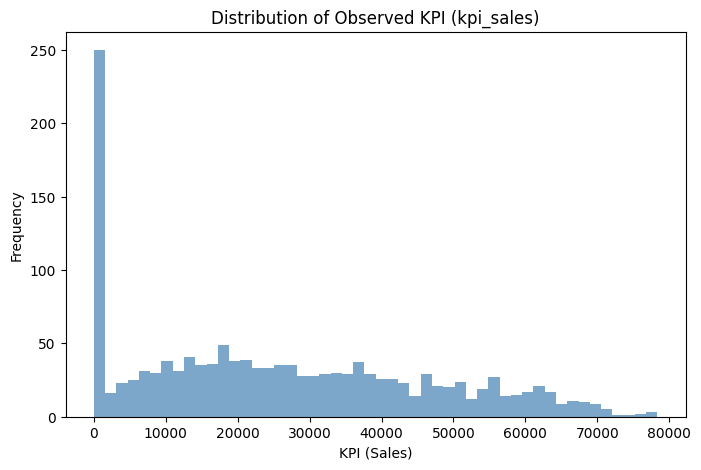

mean of KPI: 25781.957292855295


In [6]:
# Global KPI Plot  
plt.figure(figsize=(8, 5))
plt.hist(panel["kpi_sales"], bins=50, color="steelblue", alpha=0.7)
plt.xlabel("KPI (Sales)")
plt.ylabel("Frequency")
plt.title("Distribution of Observed KPI (kpi_sales)")
plt.show()

print(f"mean of KPI: {panel['kpi_sales'].mean()}")

# Informs
# Likelihood: 
# 1) Approximately symmetric, bell-shaped
# → Normal likelihood is reasonable
# → Additive error structure makes sense
# → Constant variance assumption may hold

# b) Heavy right tail skewed, strictly positive
# → Consider LogNormal or Gamma
# → Multiplicative noise is more realistic
# → Variance increases with mean
# → Use shifted Lognormal is KPI contains many 0s
# → Common for FMCG sales

# c) Zero-inflation or low integer counts
# → Poisson if mean ≈ variance
# → Negative Binomial if variance > mean
# → Zero-inflated versions if spikes at 0

# d) Heavy-tailed but symmetric
# → Student-T likelihood
# → Robust to outliers caused by unmodelled events
# → Useful when the business has many short-lived shocks

# e) Bimodality
# Could indicate:
# structural break
# seasonality with two peaks
# a shifted baseline
# or mixing of markets/products with different dynamics
# But histogram alone is not enough → must confirm via time-series plots.


# 2) Spread of distribution -> guides noise prior 
# → High spread needs wider prior
# → Low spread needs narrower prior

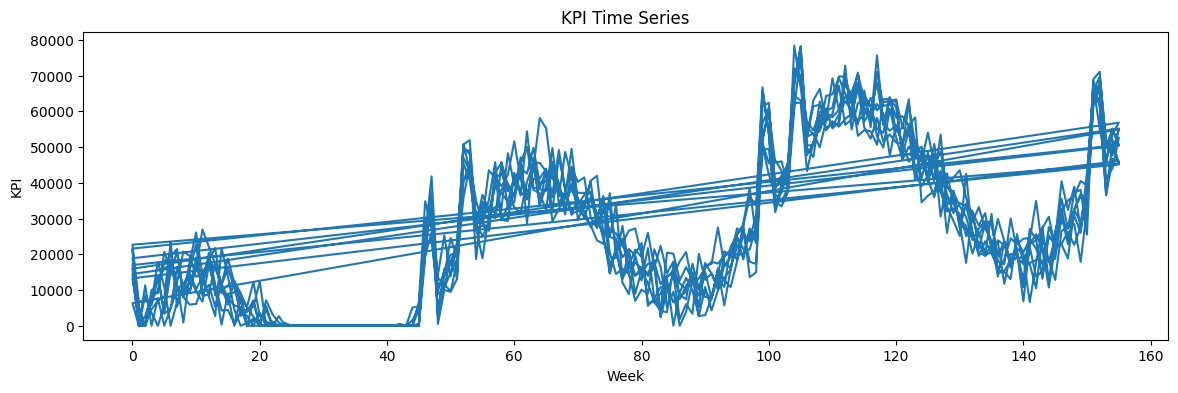

In [8]:
# Global KPI Time Series Plot
plt.figure(figsize=(14,4))
plt.plot(panel["week"], panel["kpi_sales"])
plt.title("KPI Time Series")
plt.xlabel("Week")
plt.ylabel("KPI")
plt.show()


# Detecting global trend (linear, polynominal, piecewise) 
# - upward or downward trend, acceleration or deaccelartion, structural trend changes (different slope post event - align with company calendar - piecewise trend)

# Global Structural changes
# - Sudden, permanent jump in KPI. Indicate need for permanent baseline shift

# Global Short lived, discrete temporary events - dummy variables 
# - Spikes or dips in KPI. Coupled with rolling average, shouldn't be long-term change in demand or trend level

# Global Seasonality 
# - Regular repeating yearly patterns - fourier terms
# - Sharp annual spikes - dummy variables

# Global Noise - Helps determine likelihood
# - Week-to-week jitter and variance at different KPI magnitudes. Outliers and volatilty
# - Constant variance (normal), Variance scales with mean level (lognormal), Heavy-tailed (Student T likelihood)
# - Count based (variance > mean): negative binomial

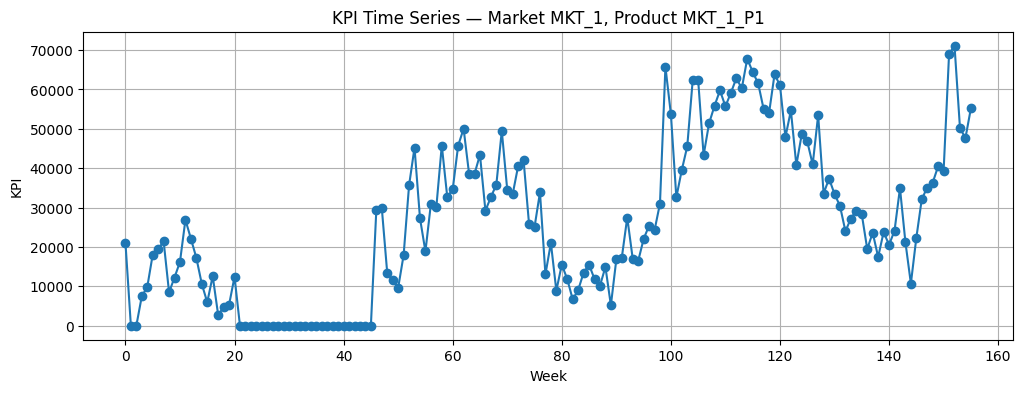

In [12]:
# Choose the market & product you want to explore
market = "MKT_1"
product = "MKT_1_P1"

temp = panel[(panel["market"] == market) &
             (panel["product_id"] == product)]

plt.figure(figsize=(12,4))
plt.plot(temp["week"], temp["kpi_sales"], marker='o')
plt.title(f"KPI Time Series — Market {market}, Product {product}")
plt.xlabel("Week")
plt.ylabel("KPI")
plt.grid(True)
plt.show()


# Insight
# Used to answer the following questions: 
# - Does market x product have similar trend, seasonality, structural breaks, events
# - How does noise/volatility compare across different market x products

# 1) When patterns in market x products look similar - use hierarichal priors (global - market - product)
# - Markets x products behave similarly across time although may have different magnitudes
# - Use hierarichal modelling with global mean and fairly tight deviation priors across markets and products

# 2) When market x products are partially similar with own quirks (sligh shift in time occured or magnitude) 
# - i.e. All markets peak around December but one market peaks slightly earlier and seasonality magnitude differs strongly
# - Use partial pooling with global mean but large deviation from global

# 3) When market x products are competely different 
# - unique seasonality, spikes, trends etc...
# - Use NO POOLING and each parameter gets its own independent parameter
# - Set prior to mu = 0 and largish sigma to allow it to learn from data

# 4) When market x product pattern is identical 
# - exact shape and scale
# - use GLOBAL POOLING - one coefficient for all markets x products
# - Very rare

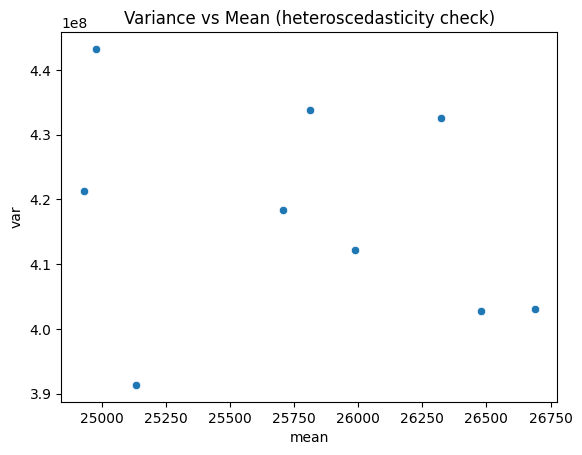

In [18]:
# KPI Summary Statistics

################################
# Coefficient of Variation
################################
# KPI CV across different market x products  
local_stats = (
    panel.groupby(["market", "product_id"])["kpi_sales"]
         .agg(["mean", "std"])
         .reset_index()
)

local_stats["cv"] = local_stats["std"] / local_stats["mean"]


# The coefficient of variation (CV) is a scale-free measure of noise in KPI. This single number tells you how large the unexplained variation is relative to the KPI level.
# Rules: 
# - Low CV (< 0.1–0.2) → KPI variance roughly constant → Normal likelihood OK
# - Medium CV (0.2–0.5) → Some heteroscedasticity → Normal still OK but check residuals
# - High CV (> 0.5) → Variance increases with the level → LogNormal or Gamma recommended
# - Very high CV (> 1) → multiplicative noise dominates → LogNormal almost certainly required

# Should set the noise prior sigma to: cv * kpi.mean()

# High CV means:
# - KPI is noisy
# - Media effects must be strong to stand out in noise - good partial pooling, stronger priors, clean tight transformations
# - Posterior Credible intervals for media effects will be wider
# - Need stronger priors or pooling to constain learnings and prevent overfitting

# Low CV means:
# - Lower noise KPI
# - Easier attribution
# - Can use weaker priors with weaker pooling

# IMPORTANT
# - If noise differs across markets x products then need hierarichal noise - different noise per market. 
# - If consistent then global noise is fine
# - This matters as markets and products have dramatically different volatility
# - CV used to set the noise prior: 
# For lognormal: σ_log ≈ sqrt(log(1 + CV^2))
# For Normal: σ_prior ≈ CV * mean(KPI)


####################################
# Mean & Median
####################################

mean_median = panel.groupby(['market', 'product_id'])['kpi_sales'].agg(["mean", "median"]).reset_index() 
mean_median["skew_indicator"] = mean_median["mean"] > mean_median["median"]

# If mean > median then right skewed - lognormal?
# If mean = median then normal or Student T likelihood should be fine

# Also if baseline mean differs dramatically across markets x products then indicates hierairhcal baseline needed. 



#####################################
# Variance Scale with KPI 
#####################################
# Variance vs level check
grouped = (
    panel.groupby(["market", "product_id"])["kpi_sales"]
         .agg(["mean", "var"])
         .reset_index()
)


sns.scatterplot(data=grouped, x="mean", y="var")
plt.title("Variance vs Mean (heteroscedasticity check)")
plt.show()


# If variance scales with KPI then multiplicative error present



# Likelihood rules
# 1) Normal
# KPI roughly symmetric
# CV small (<0.4)
# Variance doesn’t increase with level


# 2) Lognormal 
# Multiplicative noise - variance increases with mean
# CV > 0.3
# KPI strictly positive
# Skewed right

# 3) Student T
# outliers
# Heavy tailed KPIs


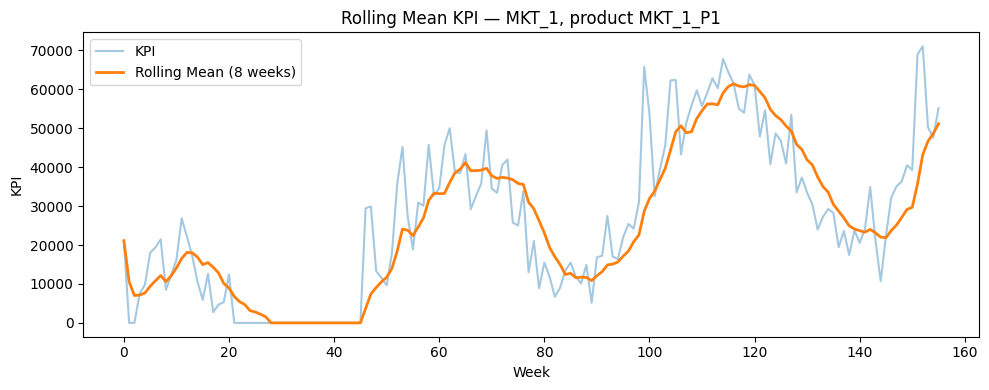

In [21]:
# Rolling mean of KPI
market = "MKT_1"
product = "MKT_1_P1"

# Add rolling mean per market × product
panel = panel.sort_values(["market", "product_id", "week"])

panel["rolling_mean"] = (
    panel.groupby(["market", "product_id"])["kpi_sales"]
         .transform(lambda x: x.rolling(window=8, min_periods=1).mean())
)


def plot_rolling_mean(panel, market, product_id):
    df = panel[(panel["market"] == market) & (panel["product_id"] == product_id)]

    plt.figure(figsize=(10,4))
    sns.lineplot(data=df, x="week", y="kpi_sales", label="KPI", alpha=0.4)
    sns.lineplot(data=df, x="week", y="rolling_mean", label="Rolling Mean (8 weeks)", linewidth=2)
    plt.title(f"Rolling Mean KPI — {market}, product {product_id}")
    plt.xlabel("Week")
    plt.ylabel("KPI")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_rolling_mean(panel, market=market, product_id=product)

# Rolling average smooths out noise to identify the underlying structure 
# - Makes sudden changes in KPI obvious (8+ weeks sustained new level)
# - Makes changes in trend more clear (piecewise trend)
# - Makes seasonality clearer - whether timing of seasonality is similar across markets x products - should be hierarichal

<Figure size 1200x400 with 0 Axes>

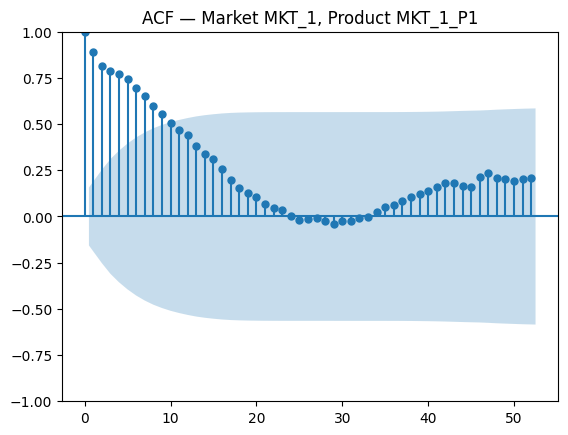

<Figure size 1200x400 with 0 Axes>

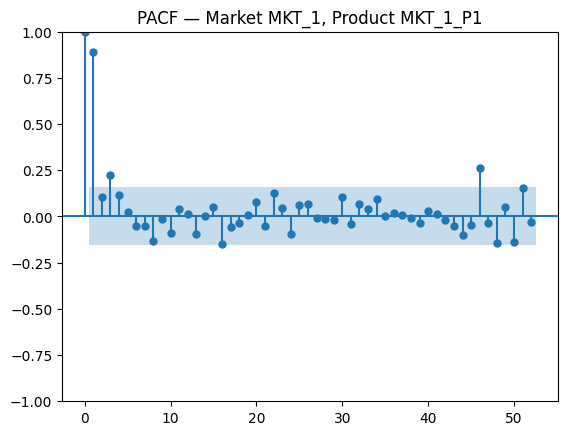

In [15]:
# Autocorrelation
# choose a market & product
m = "MKT_1"
p = "MKT_1_P1"

temp = panel[(panel["market"] == m) &
             (panel["product_id"] == p)]

plt.figure(figsize=(12,4))
plot_acf(temp["kpi_sales"], lags=52)
plt.title(f"ACF — Market {m}, Product {p}")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(temp["kpi_sales"], lags=52)
plt.title(f"PACF — Market {m}, Product {p}")
plt.show()

# ACF Graph - Identifies how todays KPI depends on previous weeks KPI. Correlation of past values
# - If KPI is highly autocorrelated with slow decay, indicates trend present. Takes time to get to 0. 
# - Small bumps and repeatable pattern indicate seaosnality
# - If KPI drops to 0 then white noise 
# - Seeing sudden drop or spike in ACF or change in pattern over time indicates potential structural break dummy needed or piecewise baseline or trend


# PACF - How much does lag-k explain KPI after controlling for smaller lags. Isolates direct dependence on a specific lag
# - Large peak at 1 indicates KPI dependen heavily on last week - simple AR1 term enough
# - If peak 2 and 3, then need AR 2 and 3 terms
# - If peak around large other lags, may indicate periodic structure - needs coupling with ACF. 



# Used for: 
# - Seeing if KPI has repeatable seasonal pattern (i.e. if lag at 52 and modelling weekly data, then annual seasonality)
# - If all markets x products have similar ACF, then seasonality trend effects can be global. If different, then use hierarichal or no pooling. 

C:\Users\JackGlover\AppData\Local\Temp\ipykernel_27080\1483151410.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  res.plot().show()


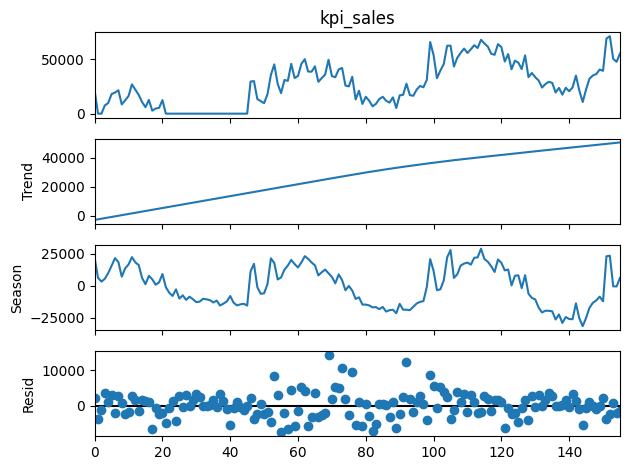

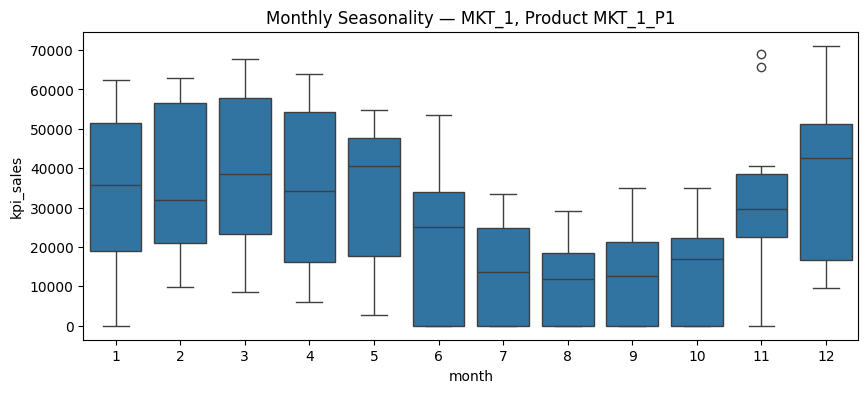

In [33]:
# Seasonal Decomposition - Inspecting seasonality and trend in KPI 
m = "MKT_1"
p = "MKT_1_P1"

# STL for individual market & product
df = panel[(panel["market"] == m) &
           (panel["product_id"] == p)].sort_values("week")

stl = STL(df["kpi_sales"], period=52)   # weekly data → 52-week seasonality
res = stl.fit()

res.plot().show()

panel["month"] = panel["date"].dt.month

df = panel[(panel["market"] == m) &
           (panel["product_id"] == p)]

plt.figure(figsize=(10,4))
sns.boxplot(data=df, x="month", y="kpi_sales")
plt.title(f"Monthly Seasonality — {m}, Product {p}")
plt.show()


# Indicates the following: 
# - Strength of seasonality: strong complex requiring 3-4 harmonics compared to simple annual seasonality requiring 1 harmonic
# - The seasonality pooling structure: Whether markets share identical seasonality (global fourier term), similar timings different amplitudes (hierarichal partial pooling), markets have completely different seasonality (no pooling). 
# - The STL Loess does not identify
# Where trend slope changes
# Detect breakpoints
# Fit piecewise linear segments
# Distinguish structural breaks vs temporary events

In [ ]:
# Plotting Channel Spend Distribution - Scale and Shape Important
plt.figure(figsize=(8, 5))
plt.hist(panel['spend_tv'], bins=50, color="steelblue", alpha=0.7)
plt.xlabel("Spend TV")
plt.ylabel("Frequency")
plt.title("Distribution of Spend TV")
plt.show()

print(panel['kpi_sales'].mean())

### **Modelling**

In [ ]:
# Splitting dataset into train and test sets
split_week = panel['week'].max()

# Split data into train and test sets
train = panel[panel['week'] <= split_week]
test = panel[panel['week'] > split_week]

In [ ]:
# Building bayesian pymc graph/model
mmm = build_mmm(train, model_cfg['modelling'])

# Sampling Model
# Extracting sampler part of config dict
sample_config = model_cfg['sampler']
# Running sampler with model config settings
idata = run_sampler(mmm, sample_config)

# Sampling Techniques
# 1) PyTensor backend
# - Default NUTS implementation 
# - Uses numpy for computation - stable 
# - CPU usage 
# - Can be slow 

# 2) Numpyro/Jax
# - JIT-complied for speed 
# - Usage on CPU, GPU, TPU
# - Faster for complex hierarichcal models 

In [ ]:
# Running prior predictive check
# Generates prior and posterior predictive groups 
prior_idata = run_prior_predictive(mmm, model_cfg['prior_predictive'])

# Running posterior predictive check
idata = run_posterior_predictive(mmm, idata, model_cfg['posterior_predictive'])

In [ ]:
# Inspecting the idata contents/groups
idata_backup = idata # incase overwrite idata object

# Define output directory to save prior and idata
out_dir = Path("runs/2025-11-14")  
out_dir.mkdir(parents=True, exist_ok=True)

# Save posterior and prior
az.to_netcdf(idata, out_dir / "posterior.nc")
az.to_netcdf(prior_idata, out_dir / "prior_predictive.nc")

# # Inspecting idata groups
# idata

In [7]:
# Loading idata objects
idata = az.from_netcdf("runs/2025-11-13/posterior.nc")
prior_idata = az.from_netcdf("runs/2025-11-13/prior_predictive.nc")

In [ ]:
# Observing number of parameters in model and compare with length of dataset 
print(len(mmm.free_RVs))

# Can observe coords and variables/posteriors in idata for analysis
idata

## **Sampling Diagnostics**

In [ ]:
# az.summary - tabular summary of posterior samples incl. mean HDIs, ESSs
summary_df = az.summary(idata, var_names = ['beta_mpc'], coords={"market": ["MKT_1", "MKT_2"], "channel": ["tv", "social"]}, stat_focus = "mean", round_to = 2, hdi_prob = 0.9)
# summary_df = az.summary(idata, var_names = ['price_mu_global'])
# Viewing first 5 rows
summary_df.head()


# =======================
# Explanation of az.summary metrics
# =======================

# ---------------------- 
# r_hat
# ----------------------
# - Measures chain convergence, compares variance within chains to variance between chains. Values near 1 optimal, >1.01 not good mixing of chains.  

#  Typical causes of bad r_hat:
# - Multimodal posteriors - chains exploring different areas because of wide priors (i.e. large addivite or multiplicative deviation) 
# - Identifiability issues - model being able to move too much into different posterior spaces (high betas, low adstocks etc...) - banana ridges present in pair plots 
# - If model has a deep hierarichicy (especially with multiplicative), ensure deviations are not too wild (Deviations from global -> market -> product -> product_market intracies etc...))
# - Wide priors on transformation parameters allow different combinations of beta, adstock and saturation to explain data equally well. 

# Other r_hat causes sometimes:
# - Tight priors - cause stickness and restrict posterior search space
# - Centered hierarichy - strong correlation/coupling between global and individual parameters causing bad posterior search 
# - Too few tuning draws - not enough for good adaptation and stable sampling
# - Strong parameter correlation/poor scaling - diagnoal ridge in the pair plot
# - Too low target acceptance - high step size and poor exploration - sampler jumps around
# - Poor initialisation: some chains start in widely separated/implausible regions of parameter space - If initial values far from high-probability posterior regions, then warmup/adaptation phase may not be long enough to converge to same region. Check and maybe change inistialisation method from "jitter+adapt_diag" to "adapt_full" - sometimes better for correlated models.
# - Wrong likelihood: Non-gaussian data and multiplicative noise but using normal likelihood. Outliers present in KPI but using normal. Count data but using normal likelihood

# ----------------------
# Bulk ESS 
# ----------------------
# Bulk ESS (Effective Sample Size) measures how effectively the sampler explores the main body of the posterior
# - Essentially, how many independent samples the MCMC chains are euqivlent to for mean and median estimates - autocorrelation effects this. 
# - MCMC relies on randomly exploring the posterior. If the chain moves slowly (high autocorrelation), many samples carry redundant information.
# - ESS corrects for that — it estimates the true information content of your posterior draws.

# Interpretation: 
# A high Bulk ESS (>400) indicates many independent samples for posteriors. 
# Low Bulk ESS (<400) suggests high autocorrelation, meaning chains are producing redundant information and not explored posterior efficiently.

# Typical causes of low Bulk ESS:
# High correlation among predictors — difficult for NUTS to navigate correlated dimensions - linear diagnal in pair plot
# Overly tight or vague priors — cause posterior to be sharply curved (tight) or flat (diffuse), both slow down exploration.
# Too few tuning steps — poor adaptation of step size and mass matrix.
# High target acceptance — sampler takes very small steps, improving acceptance but reducing efficiency.
# Centered hierarchy — creates strong coupling between group-level and global parameters.
# Large differences in parameter scales — forces the sampler to adapt very different step sizes, reducing effective mixing.
# In practice, I always check Bulk ESS alongside R-hat and tail ESS. Bulk ESS issues typically reflect slow mixing in the main posterior region, while tail ESS highlights poor exploration in the extremes.

# -----------------------
# Tail ESS
# -----------------------
# Tail ESS measures how well the sampler explores extreme regions (tails) of posterior distribution — the parts that determine credible intervals (HDIs) and uncertainty quantification.
# Interpretation: Low Tail ESS (<400) → tails are poorly explored; credible intervals may be inaccurate or overconfident.

# Typical causes of low Tail ESS:
# - Divergences or poorly explored posteriors — the sampler fails to reach the curved, constrained regions in parameter space.
# - Centered hierarchy — creates strong coupling between group-level and local parameters, trapping the sampler in narrow modes.
# - Tiny step size or excessive target_accept — the sampler moves inefficiently through high-curvature tail regions.
# - Truncated or bounded priors — sharp edges in parameter space (e.g. HalfNormal, TruncatedNormal) can produce high curvature, making tails hard to sample.
# - Pathological geometry — for instance, non-identifiable parameters or near-flat ridges where NUTS momentum can’t efficiently explore.


# If mcse_mean is small relative to posterior SD, it means your sampling noise is negligible — i.e., your posterior estimate is stable and precisely estimated.
# mcse_mean should be < 1–2% of the posterior SD for important parameters.

In [ ]:
# Trace plots - outputs the posterior distribution and chain trajectories
az.plot_trace(idata, var_names = ['beta_mpc'], coords={"market": ["MKT_1"], "product":["MKT_1_P1"], "channel":["social"]}, divergences = "top") # divergences marks

# ==================
# Trace Plot Interpretation 
# ==================
# A good trace plot looks like overlapping fuzzy caterpillars — stationary, well-mixed, and without drift.
# Also shows the posterior distribution in the left hand pane
# Bad trace plots (NOT Fizzy Caterpillars): 

# 1) Non-overlapping chains: Chains sit in distinct regions, multimodal posteriors. 
# Causes: Multimodal posteriors - can explain data in multiple different ways, multicollinearity, cnetered hierarchy, overly vague priors, poor init
# Inspect pair plots to confirm multimodality or correlated structure
# Fixes: Ensure correct likelihood and priors, add stronger priors or hierarichal shrinkage, combine correlated predictors, increase tuning, good init

# 2) Drifting - trend over iterations: Chains move gradually upward or downwards. Posterior mean keeps shifting - not stationary. 
# Causes: Too few tuning steps, poor initialization, too vauge priors, model non-identifiable
# Fixes: Increase tuning, stronger priors, different init

# 3) Jagged traces - noisy and look spiky: 
# Causes: Large step size , low tuning, strong parameter correlation, large scale differences, overly tight priors or truncated causing curvature
# Fixes: Increase target acceptance, increase tuning steps, standardise predictors


# 4) Divergences cluster in same region. 
# Causes: Neal's Funnel, tight truncated priors, centered hierarchies, high correlation amoungst parameters, step size too low

# 5) Chains Flat lining
# - Chains appear as a straight horizontal line. Normally ESS is also very low
# Causes: Parameter is fixed (posterior very tight), overly strong priors, bad init, model misspecification
# Fixes: Loosen priors, change init, add model structure



In [ ]:
# Divergences - numerical instability/sharp curvature in the posterior geometry - not exploring certain regions biasing posteriors
idata.sample_stats["diverging"].sum()

# -----------------------
# Divergences caused by: 
# -----------------------
# A divergence is when the sampler cannot accurately follow the posterior geometry because of a region with extreme curvature. 
# Causes part of the posterior space to be undersamples, biasing posteriors

# Main causes: 
# - Centered hierarichy - funnel shaped posteriors causing extreme curvature. Caused when group level variance is 0 - group parameter simiar to global mean. Pair plots show funnel with divergences at narrow part 
# - Overly tight priors - high curvature thin regions. Energy plot has sharp spikes
# - Vastly different data scales between predictors and response - Divergences near parameters with large magnitude, Energy plot long tailed, ESS low. Normalise/standardise predictors
# - Incorrect likelihood used: normal when data is strictly positive and heavily skewed, outliers in data (use student T)  
# - Too large step size (too low target accept). Divergences scattered randomly across draws, BFMI < 0.3. Increase tuning, raise target acceptance
# - Collinearity between variables - creates flat ridges and sharp valleys in posterior surface - curved geometry. Pair plots show banana ridges or diagnoal dependency. Sort multicollinearity
# - Truncated priors causing high curvature near boundaries when sampled. Check pair plots and divergences near boundaries
# - Complex interactions or unidentifiable structure - too many overlapping effects (hierarichal + interaction + nonlinear etc...) and not enough signal in the data
# - Mis-scaled priors causing unrealistic contribution to the KPI (Keep in prior predictive checks) 

# Can locate where they occur via pair plots and trace plots - helps identify where model needs fixing.
# Overall fix is to increase target acceptance but masks the issue not fixes it

In [ ]:
# Step Size - how far hamiltonian leapfrog step moves in parameter space - should be not too small nor too big as balances exploration and stability 
idata.sample_stats['step_size'].mean(("chain", "draw"))


# ==================
# Step Size 
# ==================
# The step size controls how far the Hamiltonian “leapfrog” integrator moves through parameter space per iteration.
# It determines the trade-off between exploration and numerical stability — too large causes instability; too small causes inefficient samplng
# Should be between 0.001 - 0.1 for well scaled models. <0.001 - very slow mixing, >0.1 - overly large steps 
# Too high - rejections/divergences risk. Too small - slow mixing, inefficient long sampling. 
# Typical causes of bad step size:
# - Poor scaling of predictors
# - Tight or wide priors
# - Truncated priors causing high curvature
# - Bad initialisation 
# - Multimodality - priors enabling multiple explanations of the data cause unidentifiabilty

In [ ]:
# Acceptance rate - indicates how efficiently it explores parameter space. Should be approx. to target accept argument set in sampler. 
idata.sample_stats["acceptance_rate"].mean(("chain","draw"))

# ==================
# Acceptance Rate
# ==================
# Acceptance rate measures how efficiently the NUTs sampler explores the posterior. 
# It’s the proportion of proposed Hamiltonian steps that are accepted during sampling — ideally close to the target acceptance (target_accept) you set (typically 0.8–0.95).
# If a lot smaller than Target Acc, then geometry complex and likely divergences. A lot higher, the sampler making tiny moves - high autocorrelation (low ess).  

# Causes of too low (<0.7) - sampler taking large steps risking high divergences:
# - Complex geometry
# - Tight priors
# - Strong correlated parameters
# - Poor scaling of variables
# - Not enough tunes

# Causes of too high (>0.99) 
# - Step size too small  
# - Very flat uninformative priors
# - Too higher target acceptance

# Even if set target acceptance high (0.9 >), is acceptance much lower then red flag as indicates sampler had to take large steps as geometry was too rough
# Common causes include the above 

In [ ]:
# Energy Plot - The energy plot visualizes how well the NUTS sampler explores the energy landscape (i.e. the log-probability geometry) of the posterior.
az.plot_energy(idata, kind = "hist")

# ===================
# Energy Plot
# ===================
# Should be smmothly overlapping, roughly centered at 0 and unimodel. Indicates no chain is stuck in a different region
# Typical causes of bad energy plots include: 
# - Divergences
# - Poor Scaling of parameters
# - Bad initialisation - chains start far apart
# - Overly tight/truncated priors causing high curvature
# - Multimodal posteriors - too wide priors causing unidentifiabilty
# - Centered hierarichies
# - Misspecified priors - not scaled with data
# - Correlated parameters

In [ ]:
# BFMI - Quantifies how well the HMC's momentum resampling explores the energy distribution
az.bfmi(idata)

# ===================
# BFMI
# ===================
# BFMI < 0.3 means chains move slowly, showing high autocorrelation and inefficient exploration. Causes biased posterior estimates as missed regions in posterior space
# Along with plot_energy confirms whether sampler is healthy:
# Causes of bad BFMI (<0.3):
# - Poor Scaling - variables on different magnitudes causes bad geometry
# - Hierarichal centered funnels 
# - Strong collinearity
# - Too tight prior settings restrict parameter space and cause high curvature 
# - low target acceptance causing large steps

In [ ]:
# Tree Depth - how deep the sampler had to go before stopping based on its leapfrog steps
idata.sample_stats["tree_depth"].median()

# ===================
# Tree Depth
# ===================
# Tree depth measures how far the NUTS sampler had to expand its “binary tree” of leapfrog steps before stopping at each iteration. 
# It reflects how complex or curved the posterior geometry is and how much effort NUTS needs to explore it.
# Common causes of high or frequent max tree depth: Centered hierarchies, Highly correlated predictors, Poorly scaled data, Very low step size, Tight or truncated priors 

# Check frequency of maximum depth:
# if equal = 0.25, this means about 25% of samples hit the maxium tree depth 
# <10% is acceptable (0.1)
your_max_depth = 10
(idata.sample_stats["tree_depth"] == your_max_depth).mean()

# The maximum tree depth is the upper limit on how many times the NUTS algorithm can double its leapfrog steps during exploration for each sample.
# Default is normally 10. Increasing it allows deeper exploration but increases runtime exponentially. 
# Can be set in the sampler:
# idata = pm.sample(
#     draws=2000,
#     tune=2000,
#     target_accept=0.9,
#     nuts_kwargs={"max_treedepth": 12},  # default 10
# )

In [ ]:
# Plot Rank - how even posterior samples are distributed across chains. If each chain explores the posterior evenly, ranks are uniformly distributed across chains 
az.plot_rank(idata, var_names = ['beta_mpc'], coords = {"market": ["MKT_1"], "product":["MKT_1_P1"], "channel":["social"]}, kind = 'vlines')


# =====================
# Rank Plot
# =====================
# The rank plot checks whether posterior samples are evenly distributed across chains, i.e., whether all chains are exploring the same posterior region uniformly.
# A good plot should be uniformly distributed - flat histogram - no chain should dominate particular parts of the posterior (no strong seperated colors)
# A bad plot:
# - Wavy or U-shaped distributions → some chains spend more time in extremes (e.g., 0–0.1 or 0.9–1 quantiles).
# - Separated clusters → chains are stuck in different modes or not fully mixed.
# - Unequal heights → one chain dominates part of the distribution (non-independent samples).

# Causes of bad plots include:
# - Multimodal posteriors
# - Centered Hierarichy
# - Bad initlisation
# - Tight/truncated priors
# - Low step size/low tuning

# If rank distributions are non-uniform, R-hat likely > 1.01


In [ ]:
# Plot Autocorrelation - plots autocorrelation function for each variable and chain 
az.plot_autocorr(idata, var_names=["adstock", "theta", "slope"])

# ==================
# Autocorrelation Plot
# ==================
# - Assesses how independent MCMC samplers are - how quickly each chain forgets previous state
# - Measures correlation between samples at different lags - number of steps between samples
# - High autocorrelation means that successive samples are too similar — the chain is moving slowly through the posterior space, reducing effective sample size (ESS) and not exploring posterior effectively

# - A good plot will drop sharply toward zero across few lags - means chains are exploring freely and producing near independent samples
# - Bad plot decay very slowly - samples highly correlated indicating inefficient sampling and low ess
# - Consquences include: Unreliable posteriors, long run time 

# Common causes of this include:
# - too tighter priors
# - Poor scaling / large difference in variables magnitudes 
# - High posterior correlation between parameters 
# - Step size too small (target acceptance very high) 
# - Insufficient tuning
# - Multimodal posteriors 
# - Hierarhical funnel geometry - centered hierarchy 

In [ ]:
# Pair Plot shows joint relationship between variables - should be circular blobs if good 
az.plot_pair(
    idata,
    var_names=["beta_mpc", "adstock", "theta", "slope"],
    coords={"market": ["MKT_1"], "product": ["MKT_1_P1"], "channel": ["tv"]},
    kind="scatter",
    marginals=True,
    divergences=True,  # show divergences as red dots
    textsize = 10, 
    divergences_kwargs={"color": "red", "markersize": 4}
)


# =====================
# Pair Plot
# =====================
# A pair plot visualises joint posterior relationship between parameters - showing whether they're correlated, multimodal, or poorly identified.
# It shows joint posterior and individual posteriors for variables - can check if good unimodal shape 
# Each scatter/KDE panel shows the 2-D posterior samples between two parameters, helping diagnose geometry and identifiability problems in posteriors.
# A good pair plot/posterior:
# - Shows smooth, elliptical, or slightly elongated clouds → mild correlation, well-identified independent parameters.
# - Divergences (if shown as red marks) are spread randomly, not clustered.
# - No multimodality in posteriors indicating unidentifabilty issues - mutliple values explaining the data equally well 


# Identifying where divergences/bad sampling are caused (pair plots and other diagnositics)

# 1) Funnel Shape - Neal's Funnel Centered Hierarchy
# - Pair Plot starts narrow and becomes wide. 
# Caused by: Centered hierarchies or unscaled parameters (hard geometry for HMC). Normally case between group deviations and global means in hierarchy  
# - Divergences pile up at narrow neck in pair plot
# - Sticky slow moving trace plots 
# - Bimodality in energy plot or heavy tails in histogram
# - Posteriors of deviation parameters in hierarichy may hug zero or be wide - heavy coupling with means
# Fixes: Use non-centered hierarchy

# 2) Banana ridge - Non-linear Trade off/unidentifabilty
# - Pair plot shows banana ridge with divergences appearing along the most curved region
# - Two parameters compensate to explain data equally well
# - Low ess for parameters such as transformations and coefficient 
# - Uncertainity in posteriors wide due to multiple regions of posterior explaining data equally well.  
# - PPC creible intervals wide, PPC maybe smooth not capturing peaks in actual or too spiky depending on side of trade-off  
# Fixes: Tighten priors, fixed value tranformation parameter, reduce redundant parameters in model 

# 3) Straight diagonal ridge - Linear correlation
# - Parameters are correlated 
# - Divergence red dots across the diagnoal line
# - A slowly mixing chain moves sluggishly — gets stuck in one region of the posterior space for many iterations before jumping elsewhere.
# - R hat boaderline < 1.01
# - Wide posteriors due to unidentifiabilty - may not shift from priors
# Fixes: Regularise parameters (tighter priors, ridge), Combine/aggregate correlated channels, drop redundant features

# 4) Clustered Islands - Multimodality 
# - Distinct islands with divergences near saddle between islands 
# - Trace plots in different regions non-overlapping (rhat > 1.01)
# - Multimodal posteriors
# Fixes: Simplfy model, strengthen priors, increase tuning 

# 5) Cloud smashed against an edge 
# - Divergences cluster along the boundary
# - Posterior mass stacked at prior bound
# Fixes: Replace hard truncations with softer priors. Add small offsets, adjust likelihood

# 6) No divergence patterns, just everywhere
# - Normally step size too large, too few tuning steps, unscaled predictors, poor init
# 

## Prior Predictive Checks

In [ ]:
# Histogram/KDE prior predictive check - Visualising prior predictive check and overlaying observed data at a global level 

# prior_idata is an arviz.InferenceData object returned by pm.sample_prior_predictive() and contains predicted KPI values computed from priors only
y_predicted = prior_idata.prior_predictive["y_obs"].mean(dim = ("chain", "draw")).values # (chain, draws, obs) -> (obs, )
y_predicted_mean = y_predicted.mean() 

# Extracting observed data from the idata object
y_obs = idata.observed_data["y_obs"].values 

# Plot prior predictive check with observed KPI overlay
# Samples num_pp_samples to predict y_obs using the priors - visualizes predicted_y_obs - KDE show range and shape of KPI values implied by priors before seeing any data
fig, ax = plt.subplots(figsize=(8, 5))
az.plot_ppc(
    prior_idata,
    group="prior",
    var_names=["y_obs"],
    num_pp_samples=100,
    random_seed=123,
    kind="kde",
    ax=ax
)

# Overlay observed data for comparison
az.plot_kde(y_obs, label="Observed data", ax=ax)
plt.legend()
plt.title("Prior Predictive Check with Observed Overlay")
plt.show()


# Quick check of range
print(f"Mean of prior predictive check: {y_predicted_mean}") # Should align closely with the mean of my KPI 

# Prior Predictive Scenarios: 
# Simulated KPI range too wide: Model variable priors too vague, noise prior too wrong 
# Simulated KPI range too tight: Priors too tight, noise prior too tight.
# Simulated KPI has wrong shape but scale and width ok: Wrong likelihood, wrong link function - Prior predictive symmetric but data skewed
# Simulated KPI is Multimodal: Priors too wide, multiple priors interacting multiplicatively and trading off
# Simulated KPI off actual: Priors don't match data scale and contributions generated (i.e. X_media * beta_obs) are implausibly high or low KPI contributions, Baseline prior set with unrealistic mu, May be missing model structure - combine with time series that may show predicted off actual
# Prior PC generates impossible values (i.s. negative sales): Wrong likelihood or non-bounded priors
# Prior PC too right skewed: Lognormal prior too wide



# Prior Predictive checks answer:
# - Are priors + likelihood capable of generating KPI values on right scale? 
# - Does prior predicted KPI have the right variability, smoothness and temporal structure

In [ ]:
# Temporal Time series prior predictive check - Compare observed data across products x markets to see if it lies within the 90% CI of the prior predicted draws  
# Hierarichal Prior Predictive Check - looking at individual market x product level KPI 

# ---- Select market & product ----
market = "MKT_2"
product = "MKT_2_P1"

# Generating new index to map rows to y_obs_dim_0 index (from prior predictive)
mapping = panel.reset_index().assign(y_obs_dim_0 = range(len(panel)))

# Getting index positions for the market product combo
subset_idx = mapping[(mapping["market"] == market) & 
                     (mapping["product_id"] == product)]["y_obs_dim_0"].values

# === Actual KPI values ===
actual = mapping.loc[mapping["y_obs_dim_0"].isin(subset_idx), "kpi_sales"].values

# ###################################
# # Histogram Prior Predictive Graph - granular
# ###################################
# # Prior predictive values (chain, draw, time)
# prior = prior_idata.prior_predictive["y_obs"].isel(y_obs_dim_0=subset_idx).values # (samples, obs)
# prior_flat = prior.reshape(-1)   # flatten chain × draw × time = samples

# plt.figure(figsize=(10,5))
# plt.hist(
#     actual,
#     bins=50,
#     alpha=0.5,
#     label="Actual KPI",
#     color="steelblue",
#     density=True,
# )

# plt.hist(
#     prior_flat,
#     bins=50,
#     alpha=0.5,
#     label="Prior Predictive",
#     color="salmon",
#     density=True,
# )
# plt.title("Prior Predictive vs Actual KPI Distribution — MKT_2/MKT_2_P1")
# plt.xlabel("KPI Value")
# plt.ylabel("Density")
# plt.legend()
# plt.tight_layout()
# plt.show()



######################################
# Time series prior predictive graph 
######################################

prior = prior_idata.prior_predictive["y_obs"].isel(y_obs_dim_0=subset_idx)

# Compute mean & 90% interval across (chain, draw)
prior_mean = prior.mean(dim=("chain","draw")).values
lower, upper = np.percentile(prior.values, [5, 95], axis=(0,1))

plt.figure(figsize=(12,5))

x = np.arange(len(actual))

# Prior predictive band
plt.fill_between(x, lower, upper, color="lightblue", alpha=0.4, label="Prior 90% band")

# Prior predictive mean
plt.plot(x, prior_mean, color="blue", linewidth=2, label="Prior Mean")

# Actual KPI
plt.plot(x, actual, color="red", linewidth=2, label="Actual KPI")

plt.title(f"Prior Predictive Check — {market} / {product}")
plt.xlabel("Time Index")
plt.ylabel("KPI")
plt.legend()
plt.show()

# ====== Interpretation ======
# Even if the model looks good at a global level, the model still may fail at granular levels. Reasons include: 
# - Differences across markets/products: baselines, media effects, seasonalities

# Prior predictive check at granular level being off despite global looking good incidates: 
# - Over-pooling forcing local effects close to global (sigma market & product too small) 
# - Under-pooling allowing extreme variation in local variance causing overfitting
# - Can be misspecified priors not suitable to all markets/products
# - Maybe missing structure locally (different events, seasonality, trend etc...) but doesn't show globally

# 2) Prior Predictive Check - Time series PPC
# Oberserved should lie mostly in credible interval bands and roughly centered
# Observed mean should follow realistic trend/seasonal shape
# Credible interval not too wide (blue area)

# Scenarios Time Series: 
# 2.1) Observed series mostly outside band (consistently high or low) 
# - Baseline prior mu is off, priors centered too small/large. Check priors match data scale and effect/contribution on KPI
# - Hierarichal deviations may allow large deviations and implauisble effects 

# 2.2) Band too wide
# - Noise prior too wide, prior too wide. Tighten priors on noise and other variables. 

# 2.3) Band too narrow
# - Priors too tight, including variables and noise. Loosen priors. 

# 2.4) Prior predictive mean evolves slowly/lazily over time. 
# - PPC not moving enough to capture short term movement that resembles real KPI spikes. 
# - Priors producing overly persistent, slow moving series rather than reative
# Causes: Adstock too high smoothing peaks (effect over too many weeks), Too harsh diminshing returns, large noise prior abosrbing variance, too strong trend prior explaining trend not short term flucutations, Model lacks structure (unobserved shocks not controlled) 


# 2.5) Prior predictive mean too spiky vs observed data
# - PPC moving too wildly, flucuating too much
# Causes: Adstock too low meaning spend effect forgotten instantly (all impact in week one), Noise too small not allowing flucutations, Missing smoothing structure (seasonality, trend), Overly tight priors, non-hierarichal channel modelling makes some over responsive as not pooling to an average

# 2.6) Trend Mismatch (ppc too flat and wrong slope)
# - Trend element missing or priors too tight and wrong on trend
# - Add trend elements or structual break variables, maybe time-varying intercept

# 2.7) Seasonality mismatch (ppc too flat)
# - Missing seasonality in the model
# - Priors not large enough or seasonality not correctly modelled


In [ ]:
# Checking prior predicted components of the model (mu) 
# These are deterministics set up in bayesian graph and functions that are calculated using only prior draws
# This identifies where the prior predictive check might be going wrong: blowing up, going negative/implausible, too wide or narrow (SDs)
with mmm:
    prior_parts = pm.sample_prior_predictive(
        var_names=[
            "y_obs",
            "contrib_media_ch",
            "contrib_media_total",
            "total_contrib_channel", 
            "contrib_baseline",
            "contrib_trend",
            "season_amplitude",
            "contrib_price",
            "contrib_feature",
            "contrib_competition",
            "contrib_weather",
            "contrib_temperature",
            "contrib_gdp",
            "contrib_dummies"
        ]
    )
for var in prior_parts.prior.keys():
    print(var)
    print(prior_parts.prior[var].to_dataframe().describe(), "\n")

# Good way to understand the contribution coming from each model component - are any unrealistically high or low or very wide uncertainity??  
# - If media contribution unrealistic then could be incorrect prior settings, wrong transformations applied etc... - needs investigating
# - A good way to see if the priors do not match the data scale

In [ ]:
# Check distribution of contribution computed from priors to ensure not implausible contributions - likely causing bad prior predictive checks
prior_variable_name = "contrib_baseline"
variable_mean = prior_parts.prior[prior_variable_name].mean(dim = ("obs"))
az.plot_posterior(variable_mean)

In [ ]:
# Plotting individual prior distributions on random variables to inspect range
# Change var_names input to inspect different priors - ensure hierarical priors are aligned with data scale and not too wide or tight - weakly informative 
az.plot_posterior(
    prior_idata,
    group = "prior",
    var_names=["beta_mpc"],
    coords={"market": ["MKT_1"], "product":["MKT_1_P1"]}
)

# This: 
# - Validates priors reflect reasonable domain beliefs and are realistic
# - Bad priors cause convergence issues 
# - Is the effect size plausible given the KPI range? 
# - Are prior too tight? 
# - Are priors too vague/restrictive? 

In [ ]:
# Visualizes the dependency structure between hierarchical media priors across markets/channels
# Helps to see if priors are independent, correlated, or unrealistically wide/tight before fitting the model.
az.plot_pair(
    prior_idata,
    group = 'prior',
    var_names=["beta_mpc"],
    coords={"market": ["MKT_1", "MKT_2"], "product": ["MKT_1_P1"], "channel": ["tv", "social"]},
    kind="scatter",
    marginals=True
)

# Diagonal upward relationship indicates strong positive correlation between two parameters
# If for the same channel but different markets then OK because they share the same global mean - should be correlated 
# So would expect them to move together - The model believes that the two markets likely have similar baseline TV effects, but allows for some individual deviation.
# If pattern was completely scatted cloud, would indicate priors are independent and no pooling across markets

In [ ]:
# This plot shows whether your model’s priors think there’s any built-in link between how effective media is and how sensitive sales are to price before seeing any data.
# If the dots form an upward line, it means your priors assume: when price effect is strong, media also tends to look strong.
# If the dots look like a cloud with no pattern, it means: your model treats price effect and media effect as independent — which is what you normally want.
# So basically: this checks whether your model is already “baking in” a relationship between price and media effects, or if it’s letting the data decide that later.

az.plot_pair(
    prior_idata,
    group = 'prior',
    var_names=["beta_mpc", "price_mu_global"],
    coords={"market": ["MKT_1", "MKT_2"], "product": ["MKT_1_P1"], "channel": ["tv", "social"]},
    kind="scatter",
    marginals=True
)

# If you see correlation in the prior pair plot, it’s a warning that your model’s structure or priors are linking things that should be independent
# The sampler may confuse media and price effects, causing identifiability problems (e.g., media taking credit for price-driven changes).
# Posteriors might not reflect the data properly — they’ll partly just echo that prior relationship.

### Posterior Predictive Check & In-Sample Prediction

In [ ]:
# ------------------------------------------------------------
# Posterior Predictive Check (PPC) - Histogram
# ------------------------------------------------------------
# Draws coefficient samples from posteriors to predict y across each time period 
# Overlays posterior predictive simulated KPI (blue) with observed KPI (black)
# The PPC should be assessed before sampling diagnostics and holdout evaluation 

# Purpose:
# - Evaluates whether the fitted model can realistically reproduce observed KPI 
# - If credible intervals not too wide and observed KPI values lies within them, indicates KPI variance is captured
# - Major difference highlights potential model misspecifications, wrong likelihoods, priors, transformations, or missing covariates (temporal variables missing)

# Stacking chains and draws to make y_obs shape (obs, samples). This is the shape required for plot_PPC
idata_ppc = idata.copy()
idata_ppc.posterior_predictive["y_obs"] = (
    idata_ppc.posterior_predictive["y_obs"]
    .stack(sample=("chain", "draw"))
) # (samples,obs)

# Posterior Predictive Check
az.plot_ppc(
    idata_ppc,
    group="posterior",            
    var_names=["y_obs"],          
    num_pp_samples=1000,          # number of different "worlds" simulated 
    figsize=(10, 5),
    alpha=0.2                     # transparency of overlayed simulated curves
)

# ------------------------------------------------------------
# INTERPRETATION GUIDE
# ------------------------------------------------------------
# 1) Good Fit — Posterior predictive Matches Observed Distribution. What you see
# Observed KPI closely aligned with posterior predictions (different worlds)
# PPC replicates general shape and scale of KPI (good mean + variance + shape fit).


# 2) Posterior Mean Too Wide vs Observed (Posterior Predictive Too Dispersed). 
# What you see: 
# - Blue KDE curves much wider than the black observed line. Simulations cover a larger KPI range than observed.
# - High uncertainty in posteriors → model not confident
# Likely MMM Causes
# - Noise σ prior too large (weak)
# - Very weak priors on variables (i.e. media) → model not guided enough due to wide uncertainity
# - Hierarchical σ too wide → markets/products vary excessively from global mean
# - Missing structure leads to inflated noise
# - Multicollinearity or noisy data making signal not clear and posteriors wide/uncertain
# Fixes:
# - Tighten noise prior (e.g., HalfNormal with lower scale (kpi.mean() * CV)
# - More informative priors on media and variables
# - Reduce σ_market / σ_product priors in hierarichy
# - Check correct KPI scaling (log or per-capita if needed)
# - Check priors scaled to correct data scale
# - Worth checking noise in data and how much posterior moves from prior - indicate whether there's strong or weak signals 


# 3) Posterior mean Too Narrow vs Observed (Posterior Predictive Over-Confident)
# What you see
# - Blue curves tightly centered with observed much wider.
# - Predictive distribution underestimates variability in oberserved
# Interpretation:
# - Over-confident/over-regularisation → model too rigid.
# Likely MMM Causes: 
# - σ prior too tight
# - Strong priors on media coefficients
# - Excessive pooling (hierarchical shrinkage too high)
# - Wrong likelihood (Normal when data has heavy tail)
# Fixes:
# - Relax σ prior (increase scale)
# - Loosen hierarchical priors
# - If outliers/heavy tails: use Student-T likelihood
# - Add missing noise drivers (promo, events, seasonality)


# 4) Observed Centered Differently from Posterior Predictive Mean
# - Predicted values consistently over or under-shoot observed KPI.
# - Difference in mean suggests bias in model (mis-specification
# Interpretation:
#   Model’s expectation (μ) is wrong
# Possible Causes:
# - Missing temporal patterns (trend, seasonality, holiday spikes).
# - Incorrect transformations (adstock/hill misspecification).
# - Incorrect prior speifications (Check prior vs posterior to see if posterior hugging prior bounds)
# - Mis-scaled priors - do not match data scale (check prior predictive check) 
# - Hierarchical pooling too restrictive (markets can’t deviate enough)
# - Global mean in hierarichies wrong 
# - Baseline intercept too low or high
# Fixes:
#   - Add missing covariates: trend terms, Fourier seasonality, month/holiday dummies. (Time Series PPC helps with this) 
#   - Check adstock and saturation transformations for each channel (Time Series PPC helps with this - too smooth or spiky with increase in media spend indicate incorrect transformations)
#   - Relax hierarchical deviation priors (σ_market, σ_product) - not too much though to cause implausible variation. 
#   - Check Global means in hierarchy
#   - Consider separate baseline intercepts per market/product.
#   - Check prior settings match data scale

# 4) Shape Mismatch (Skew, Heavy-Tails, or Multi-Peaks Not Captured)
# What you see
# - Observed density has different shape vs predictive: e.g., observed is skewed, multimodal, or heavy-tailed
# Interpretation
# - Likelihood mis-specified or key structural drivers missing.
# Likely MMM Causes
# - Using Normal or Gamma likelihood with large data when skewed postive KPI (e.g., sales, donations)
# - Missing business structures (promos, seasonality, breakpoints)  (Time Series PPC will help this) 
# - Incorrect KPI transformations - check PPC & time series residuals - if too smooth when media spend high, or too spiky, transformations incorrect. 
# Fixes
# - Try Log Normal likelihood or Student T is residual tails too heavy - outliers
# - Add Gaussian Random Walk or time-varying baseline to capture more structural 
# - Add seasonality, month, promo & holiday dummies


# PPC won’t reveal:
# Non-identifiability - Pair plots, individual posteriors and Rhat/trace plots will 
# Multimodality - same as above
# High parameter correlation - EDA and pair plots
# Centered hierarchy funnels - Pair plots Neals funnel
# Badly mixed chains (trace plots)

In [ ]:
# ------------------------------------------------------------
# Posterior Predictive Check (PPC) - Time-Series
# ------------------------------------------------------------

# --- Combine posterior predictive draws ---
y_pp = idata.posterior_predictive['y_obs'].stack(samples=("chain", "draw")) # (samples, obs)
y_pp_mean = y_pp.mean(axis=0) # (obs,)

# --- Observed data ---
y_obs = idata.observed_data['y_obs'].values # (obs,)

# --- HDIs (credible intervals) ---
hdi90 = az.hdi(y_pp, hdi_prob=0.90)  # 90% interval
hdi50 = az.hdi(y_pp, hdi_prob=0.50)  # 50% interval

# Extract lower and upper bounds
hdi90_low  = hdi90.sel(hdi='lower').values
hdi90_high = hdi90.sel(hdi='higher').values

hdi50_low  = hdi50.sel(hdi='lower').values
hdi50_high = hdi50.sel(hdi='higher').values

# Plot Time Series PPC
plt.figure(figsize=(12, 5))

plt.plot(y_obs, color="black", label="Observed KPI")
plt.plot(y_pp_mean, color="blue", label="Posterior Predictive Mean")

# 90% HDI
plt.fill_between(
    np.arange(len(y_obs)),
    hdi90_low, hdi90_high,
    color="blue", alpha=0.15, label="90% HDI"
)

# 50% HDI
plt.fill_between(
    np.arange(len(y_obs)),
    hdi50_low, hdi50_high,
    color="blue", alpha=0.3, label="50% HDI"
)

plt.legend()
plt.title("Time Series Posterior Predictive Check")
plt.xlabel("Time")
plt.ylabel("KPI")
plt.show()



# Time series Posterior Predictive Check - Global
# 1) Good Fit (What You Want to See)
# Visual pattern:
# - Black line (observed) lies mostly lies within 50% & 90% credible bands of PPC (coverage)
# - Posterior mean tracks general trends and seasonality of observed
# Interpretation:
# - Model explains the majority of predictable variation
# - Mean structure μ is correctly specified
# - Priors not in conflict with data
# - Noise model adequate
# - Temporal structure is appropriately captured


# 2) Model Too Uncertain (Credible Intervals Too Wide)
# Visual pattern:
# - Bands are very wide around observed
# - PPC mean wobbly or flat
# Meaning:
# - Model posteriors have high uncertainty / weak identifiability.
# Likely causes:
# - Missing model structure causes omitted variable bias, biasing posteriors increasing uncertainity
# - Weak data signal not informing parameters strongly so reverts to prior (couple with EDA correlation analysis) 
# - Multicollinearity causing wide posteriors and unidentifiabilty
# - Noise σ too wide: Overestimates unexplained variance as allowed to
# - Priors too vague: Coefficients allowed to wander and pick up noise
# - Excessive pooling: Shrinks market/product effects too much meaning inflated noise
# Fixes:
# - Add structure that reduces unexplained noise
# - Tighten noise prior (smaller HalfNormal scale)
# - Add weakly informative priors for media effects and other variables
# - Reduce pooling strength: increase sigma_market, sigma_product allows capturing structure
# - Improve feature engineering (better transformations)


# 3) Model Too Confident (Predictive Intervals Too Narrow)
# Visual pattern:
# - Bands are tight but observed sits outside frequently.
# Meaning:
# - Model underestimates uncertainty → overfitting or mis-modelled noise.
# Likely causes:
# Causes:
# - Noise σ prior too tight: Model forced to fit every fluctuation biasing posteriors - overfitting
# - Likelihood wrong: assumes Gaussian noise but data has heavy tails or skewed distribution with multiplicative error 
# - Too restrictive priors on coefficients - tight posteriors that hug priors may be seen in prior x posterior comparison
# Fixes:
# - Loosen noise σ prior
# - Use Student-T likelihood (handles outliers) or Lognormal (Muplicative error)
# - Add market-specific noise terms in hierarichy
# - Add latent component trend / AR terms if needed


# 4) Systematic Under/Over Prediction (Bias)
# Visual pattern:
# - Credible interval bands consistently don’t contain observed (Low coverage)
# Meaning:
# - Mean structure (μ) is wrong → biased mu.
# Likely causes & Fixes:
# - Missing trend, seasonality, control components 
# - Add linear/poly trends or time varying baseline using a Gaussian Process
# - Adstock/Hill mis-specified
# - Widen and recenter priors. Allow different priors for different variables
# - Pooling too strong in hierarichies not allowing variables to learn real signal
 
# 5) Observed changes faster than predictions (model too smooth)
# - Adstock too high or trend too smooth missing peaks in actuals
# - Saturation too harsh - Shrinking actual media effects causes missed peaks
# - Not including dummy variables to capture event and promo variation
# Fixes:
# - Reduce adstock α, add local-level transformation variation, loosen adstock priors (beware of trade offs though - banana ridges in pair plots)
# - Shrink dim return transformations to allow less immediate saturation in media channels
# - If still missing variation, add time varying baseline or dummy variables to capture events if coincide

# 6) Predictions fluctuate more than observed (too spiky)
# - Adstock too low meaning media only shows immediate effect
# - Dim returns almost linear, so no/little saturation at high media spends
# Fixes: 
# - Increase adstock α, tighten priors
# - Increase saturation harshness

In [ ]:
# Coverage - % of actual observations that are inside the 50% and 80% HDIs of the posterior predictive check
coverage_50 = np.mean((y_obs >= hdi50_low) & (y_obs <= hdi50_high))
coverage_90 = np.mean((y_obs >= hdi90_low) & (y_obs <= hdi90_high))
print(coverage_50*100, coverage_90*100)

print(f"\nCoverage for {market} / {product}:")
print(f"50% Coverage: {coverage_50*100:.1f}%")
print(f"90% Coverage: {coverage_90*100:.1f}%")


# Coverage
# 50% coverage → how often the true KPI falls inside the middle 50% of the posterior predictive distribution - well calibrated model should be 50% coverage
# 90% coverage → how often it falls inside the 90% predictive interval - well calibrated model should be 90% 

# Interpretation: 

# 1) Under-Coverage (intervals too narrow / biased predictions) - (e.g., 50% HDI < 30% coverage, 90% HDI < 70% coverage)
# Observed data frequently fall outside the posterior predictive intervals.
# Causes
# - Noise σ prior too tight → predictive variance underestimated making intervals narrow
# - Over-shrinkage in hierarchical priors → inadequate market/product deviation causing uncaptured variance
# - Priors on media/controls too tight → μ too rigid
# - Missing structure (trend, seasonality, holiday spikes, promo events, breakpoints)
# - Wrong likelihood (Normal on heavy-tailed / skewed KPI → thin predictive tails)
# - Mis-specified transformations (adstock, saturation, logs)
# - Insufficient noise drivers included (promo, competitor, weather etc.)

# 2) Over Coverage 
# Observed data fall within posterior predictive intervals too often  (e.g., 50% HDI > 70% coverage, 90% HDI > 98% coverage)
# Interpretation
# Model is under-confident / underfitting, predictive uncertainty too large.
# Causes
# - Noise σ prior too weak → posterior noise variance inflates
# - Variable priors too vague → wide betas → uncertain μ estimates
# - Multicollinearity / unidentifiability → inflated uncertainty
# - Omitted variables (trend, seasonality, holidays, promos) → unexplained variance → wide σ
# - Misspecified transformations (adstock, saturation, logs)
# 0 Wrong likelihood (Normal instead of LogNormal/NegBin) → variance form mismatch → σ inflates artificially causing wide intervals

In [ ]:
# In sample prediction metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_mean = idata.posterior_predictive['y_obs'].stack(dims = ("chain", "draw")).mean(axis = 1)
y_obs = idata.observed_data['y_obs'].values

# Computing the error metrics
rmse = np.sqrt(mean_squared_error(y_obs, y_mean))
mae = mean_absolute_error(y_obs, y_mean)
mape = np.mean(np.abs((y_obs - y_mean) / y_obs)) * 100
r2 = az.r2_score(y_obs, y_pred)

# Bayesian R_2 
y_pred = idata.posterior_predictive['y_obs'].stack(dims = ("chain", "draw")).values.T

print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"MAPE: {mape:.1f}%")
print(f"r2: {r2[0]}")


# Using measurement types:
# 1) RMSE: When large prediction errors are more costly or important to detect
# Pros: Good for detecting poor peak fit
# Cons: Can make model look worse than it is, is scale dependent

# 2) MAE: to understand typical absolute errors without extra penatly for large misses
# - On average, model predictions were £X off
# Pros: Good for general accuracy comparisons 
# Cons: Doesn't highlight occasional big misses, is scale dependent

# 3) MAPE: Average % prediction error: How far off predictions are relative to the true value
# - Pros: scale free, gives simple % term error, domain expert friendly, good for compare accuracy across products x markets
# - Cons: Undefined when KPI = 0

# 4) R2: 

In [ ]:
########################################
# Market x product PPC
########################################

# Select market & product
market = "MKT_2"
product = "MKT_2_P1"

# Create new index in data to map rows to correct market x product indicies
mapping = panel.reset_index().assign(index = range(len(panel)))

# Get index positions for the market x product
subset_idx = mapping[(mapping["market"] == market) & 
                     (mapping["product_id"] == product)]["index"].values

# Extract Actual KPI values for the market x product segment
actual = mapping.loc[mapping["index"].isin(subset_idx), "kpi_sales"].values


# --- Granular PPC Histogram ---
# Extracting posterior predictive values for specific market x product shape: (chains, draws, obs) 
posterior = idata.posterior_predictive["y_obs"].sel(y_obs_dim_0=subset_idx).values
posterior = posterior.reshape(-1)   # flatten chain × draw × time for this market x product

# --- Plot Posterior Predictive vs Actual ---
plt.figure(figsize=(10, 5))

# Posterior vs actual
plt.hist(actual, bins=100, alpha=0.4, density=True, label="Actual KPI")
sns.kdeplot(posterior, fill=True, alpha=0.4, label="Posterior Predictive")
plt.xlim(left=0)

plt.title(f"Posterior Predictive vs Actual KPI Distribution\n{market} / {product}")
plt.xlabel("KPI Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# === Time series Posterior Predictive Graph ===
posterior = idata.posterior_predictive["y_obs"].isel(y_obs_dim_0=subset_idx)

# Compute mean & 90% interval across (chain, draw)
posterior_mean = posterior.mean(dim=("chain","draw")).values
lower, upper = np.percentile(posterior.values, [5, 95], axis=(0,1))

# Plotting Graph
plt.figure(figsize=(12,5))
x = np.arange(len(actual))

# Prior predictive band
plt.fill_between(x, lower, upper, color="lightblue", alpha=0.4, label="Posterior 90% band")

# Prior predictive mean
plt.plot(x, posterior_mean, color="blue", linewidth=2, label="Posterior Mean")

# Actual KPI
plt.plot(x, actual, color="red", linewidth=2, label="Actual KPI")

plt.title(f"Posterior Predictive Check — {market} / {product}")
plt.xlabel("Time Index")
plt.ylabel("KPI")
plt.legend()
plt.show()

# ====== Interpretation ======
# Even if the model looks good at a global level, the model still may fail at granular levels.
# Reasons include: 
# - Over-pooling forcing local effects close to global (sigma market & product too small) 
# - Under-pooling allowing extreme variation in local variance causing overfitting
# - Can be misspecified priors not suitable to all markets/products
# - Maybe missing structure locally (different events, seasonality, trend etc...)

In [ ]:
# Coverage Granular Level - % of actual observed falling within credible intervals of the granular PPC

# Select market & product
market = "MKT_2"
product = "MKT_2_P1"

# Create new index in data to map rows to correct market x product indicies
mapping = panel.reset_index().assign(index = range(len(panel)))

# Get index positions for the market x product
subset_idx = mapping[(mapping["market"] == market) & 
                     (mapping["product_id"] == product)]["index"].values

# Extract Actual KPI values for the market x product segment
actual = mapping.loc[mapping["index"].isin(subset_idx), "kpi_sales"].values


# --- Granular PPC Histogram ---
# Extracting posterior predictive values for specific market x product shape: (chains, draws, obs) 
posterior = idata.posterior_predictive["y_obs"].sel(y_obs_dim_0=subset_idx).values

# --- HDI Bands ---
hdi50 = az.hdi(posterior, hdi_prob=0.50)
hdi90 = az.hdi(posterior, hdi_prob=0.90)

# Extract just the variable inside the dataset (usually named "y_obs")
hdi50_low  = hdi50[:, 0]
hdi50_high = hdi50[:, 1]

hdi90_low  = hdi90[:, 0]
hdi90_high = hdi90[:, 1]

# --- Coverage ---
coverage_50 = np.mean((actual >= hdi50_low) & (actual <= hdi50_high))
coverage_90 = np.mean((actual >= hdi90_low) & (actual <= hdi90_high))

print(f"50% Coverage: {coverage_50*100:.1f}%")
print(f"90% Coverage: {coverage_90*100:.1f}%")


# | Symptom                             | Meaning                                               | Fix                                                 |
# | ----------------------------------- | ----------------------------------------------------- | --------------------------------------------------- |
# | Coverage low & intervals too narrow | Model overconfident                                   | Increase σ prior, add structure                     |
# | Coverage low & intervals wide       | Model missing important features                      | Add external drivers, inspect unidentifiabilty      |
# | Coverage high but intervals huge    | Model uninformative                                   | Priors too vague or overpooling. Noise prior too wide |
# | Coverage high and narrow            | Perfect – model both accurate & sharp                 | Keep current structure                            |
# | Low coverage in specific markets    | Pooling too strong: model not learning local patterns | Reduce hierarchical shrinkage (market_sigma etc...|
# | Systematic bias in one product only | Missing product-specific media or baseline            | Add product-level effects/variables               |


## **Residual Analysis**

### **Residuals** 
- Indicate what could not be explained by the model (i.e. the mean structure - mu) <br>
**Process**: <br>
- 1) Structural changes - (mu) 
| Residual Pattern               | Meaning                                  | Fix                               |
| ------------------------------ | ---------------------------------------- | --------------------------------- |
| Trend in residuals             | Missing trend                            | Add trend component               |
| Seasonal waves                 | Missing seasonality                      | Add Fourier or seasonal dummies   |
| Residuals differ by market     | Over-pooling / missing market intercepts | Add hierarchical components       |
| Clusters around promo periods  | Missing promo / events features          | Add event variables               |
| Residuals correlate with media | Wrong media transformation               | Tune adstock/saturation or priors |


- 2) Noise model (likelihood) <br>
After residuals show no systematic structure, check for distributional misfit
| Residual Symptom                               | Diagnosis                                   | Likelihood Fix                |
| ---------------------------------------------- | ------------------------------------------- | ----------------------------- |
| Heavy tails                                    | Data has large shocks out of Gaussian range | Student-T                     |
| Right-skewed KPI & multiplicative errors       | Multiplicative error structure              | LogNormal likelihood          |
| Variance grows with level (heteroskedasticity) | Proportional error                          | LogNormal                     |
| Zero-inflation                                 | Too many zeros                              | Zero-inflated or hurdle likelihood |


**Incorrect likelihood can cause**: 
| Category Impacted                          | What Goes Wrong                                          | Why It Happens                                                                                 | Practical Consequence                                                                                  |
| ------------------------------------------ | -------------------------------------------------------- | ---------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------ |
| **Uncertainty Calibration**                | **Biased uncertainty (miscalibrated HDIs)**              | Normal enforces constant variance, but real KPI noise grows with level                         | Too narrow CIs on high values → false confidence; too wide CIs on low values → unnecessary uncertainty |
| **Model Fit**                              | **Poor fit at high KPI values**                          | Normal assumes additive noise; KPI has multiplicative noise and skew                           | Peaks and troughs fall outside HDIs, PPC shows systematic misfit, model underfits real volatility      |
| **Sampling & Convergence**                 | **More divergences and sampling instability**            | Model forced to fit one σ to multiple noise regimes → posterior geometry becomes funnel-shaped | Slow sampling, low ESS, divergences, unreliable posteriors even with high target_accept                |
| **Attribution Accuracy** *(Most critical)* | **Noise spills into coefficients and baseline**          | Model tries to explain variance that should be noise by adjusting betas and intercept          | Inflated or deflated media effects, wrong channel rankings, biased ROI and budget recommendations      |
| **Residual Behaviour**                     | **Residuals show skew, heavy-tails, heteroskedasticity** | Likelihood cannot represent true error distribution                                            | Structural residual patterns persist even after μ is fixed                                             |
| **Pooling Behaviour**                      | **Hierarchy over-shrinks or under-shrinks**              | σ misfit forces hierarchical components to compensate                                          | Markets/products appear more similar or different than reality                                         |
| **Inference Stability**                    | **Posterior sensitive to priors and initialisation**     | Likelihood doesn’t match data-generation process                                               | Model becomes fragile — small data changes shift results significantly                                 |
| **Predictive Accuracy**                    | **Forecasts inaccurate at scale extremes**               | Wrong noise model penalises large deviations asymmetrically                                    | Poor performance on high-sales weeks (e.g., Black Friday, campaigns, seasonality peaks)                |


In [ ]:
#### ===== Time series residual plot - Global ==== 

# Extracting oberserved and PPC values
y_obs = idata.observed_data['y_obs'].values # (obs,)
y_pred = idata_ppc.posterior_predictive['y_obs'].shape # (obs, samples)

# Computing residuals
residuals = y_obs[:, None] - y_pred # (obs, sample)

# Calculating mean and HDIs
res_mean = residuals.mean(axis=1) # (obs,)
np.percentile(residuals, 5, axis=1).shape # (obs,)
res_high = np.percentile(residuals, 95, axis=1) # (obs,)

plt.fill_between(range(len(res_mean)), res_low, res_high, alpha=0.3)
plt.plot(res_mean)
plt.axhline(0, color="black")
plt.title("Residuals Over Time (90% bands)")
plt.show()

# -- Interpretation -- 
# 1) Residuals showing random scatter around the 0, no structure or shape, no autocorrelation
# - Model explains systematic variation well 

# 2) Wave-Like repeating patterns 
# - Indicates that seasonality is still present in residuals and needs adding to mu (maybe more fourier terms)

# 3) Trend remaining in residuals
# - Residuals shift up and down over time
# - Indicate that trend is mis-specified or missing structural changes (structural break in baseline)

# 4) Systematic under/over prediction 
# - Residual bands consistently over or under 0 for long periods 
# - Indicates missing variables, maybe incorrect media transformations
# - Could be excess pooling in hierarichy

# 5) Residuals band widens or shrinks with KPI level
# - Heteroskedascity indicates a likelihood mismatch
# - Try studentT, Lognormal 
# - Could indicate missing structure/variables

# 6) Large spikes in residuals
# - Not account for external effects (campaigns, promos, supply shocks) through dummy variables
# - Transformations such as adstock may be too harsh causing sharp peaks in residuals

# 7) If credible bands are extremely wide - model is uncertain about predictions - weak priors or high noise or unidentifiabilty


## Indicate incorrect transformations (Adstock & Dim Returns)
# 1) Adstock too high - model become too smooth and predictions fail to capture short term spikes. Residuals show sudden jumps after model campaigns that the model cannot react to - this may also be external influences
# 2) Adstock too low - model becomes too reactive/spiky. Effects die too quickly after campaigns and media spend impact concentrated in same weeks - too much week-to-week noise in residuals
# 3) Dim return too strong - channels saturate quickly, after small spend increases incremental effect minimal. Model underfit media impact attributing to other variables. Residuals show underprediction at high spends
# 4) Dim return too weak - No saturation, overprediction in high spend periods

In [ ]:
# === Residuals vs fitted values ===

# Collecting the predicted values and graphing with residuals
y_obs = idata.observed_data['y_obs'].values                  # (T,)
y_pred = idata_ppc.posterior_predictive['y_obs'].values      # (T, draws)

# Residuals (T, draws)
residuals = y_obs[:, None] - y_pred

# Mean prediction per time point
y_mean_pred = y_pred.mean(axis=1)      # mean across draws → (T,)
res_mean = residuals.mean(axis=1)      # (T,)

# Plot
plt.figure(figsize=(6,4))
plt.scatter(y_mean_pred, res_mean, alpha=0.4)
plt.axhline(0, color="black")
plt.xlabel("Fitted Values (Mean Prediction)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()


# === Interpretation ===
# 1) Random cloud around mean
# - Residuals scattered evenly around line
# - No visible trends, shapes and variance constant across fitted values

# 2) Linear relationship - forms a strong diagnoal line 
# - Residuals increase/decrease along as fitted values increase 
# Causes: 
# - Missing variables - temporal or media variables
# - Wrong link function or likelihood
# - May need time varying components added to the model
# - Noise and variable priors too tight
# - Hierarichy too tight - masking variation

# 3) U shaped residuals
# - Residuals high at low & low at high fitted values, near zero in the middle (U-shaped)
# - Model is linear but data is non-linear - systematic underpredictions at extremes 
# - Hill saturation too weak - not capture non-linear relationship in media effects or other variable effects
# - Model may be missing seasonal or trend elements (maybe non-linear temporal components - polynominal)

# 4) Fan shaped residuals (variance increases with fitted values)
# - Residuals spread widens as fitted values increases
# - Variance of errors changes with magnitude of predictions
# - Model may assume constant variance (normal likelihood) but data noise scales with KPI
# - Incorrect likelihood used - adjust to gamma, lognormal or student T
# - Maybe use a log link

# 5) Residuals cut off sharply at a line 
# Residuals cluster at a boundary or appear truncated 
# Causes:
# - Truncated priors cutting off parameter space
# - Half-Normal / Half-Cauchy priors forcing positivity when negative values allowed
# - Clipped media transformations (common in poorly implemented adstock)
# - Hard caps in pre-processing (e.g., capping outliers)
# - Harsh boundaries on media transformations

In [ ]:
# === Residual Histogram ===
plt.figure(figsize=(6,4))
sns.histplot(res_mean, kde=True)
plt.axvline(0, color="black")
plt.title("Distribution of Residuals (Mean across draws)")
plt.show()


# === Interpretation ===
# 1) Bell-shaped centered around 0 - no bias good model

# 2) Entire or large proportion of distribution < 0 - systematic overprediction. 
# Causes: 
# - Missing modelling parameters 
# - Baseline too high
# - Media effects too strong
# - Saturation too weak - over attributing media effects
# - Missing negative drivers
# - Unmodelled elements missing

# 3) Entire distribution > 0 - systematic underprediction. 
# Causes: 
# - Missing positive modelling parameters
# - Baseline too low
# - Media effects too weak - Saturation too high, adstock too low - under attributing media effects

# 4) Too narrow/low variance (overconfident model) 
# - Underestimates uncertainity - model forced to learn noise and become certain
# Causes: 
# - Noise prior too small 
# - Priors too tight 
# - Over pooling in hierarichies not enabling learning
# - PPC may look too perfect as capturing noise

# 5) Too wide/high variance (overconfident model) 
# - Overestimates uncertainity
# causes: 
# - Noise prior too wide 
# - Priors too wide 
# - Under pooling in hierarichies
# - Adstock too low
# - missing structure

# 6) Skewed Residuals → Wrong Likelihood or Link Function
# Histogram leans left or right (not symmetric).
# Causes:
# - Using Normal likelihood on raw scale when KPI is skewed
# - Missing log-transform or wrong link function
# - Heteroskedasticity (variance increases with mean)
# - Residuals vs fitted will often show a fan shape alongside skew
# Fix:
# - Use log(KPI) + Normal or LogNormal/Gamma/Student-T likelihood
# - Apply log link

In [ ]:
# === Autocorrelation Function of residuals ===
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(6,3))
plot_acf(res_mean, lags=40)
plt.title("ACF of Residuals")
plt.show()


# -- Interpretation --
# 1) Bars high at lag 1, 2, 3, 4 
# - Residuals today still depend on yesterday 
# - Indicates model hasn't captured short-term dynamics 
# - Model is too smooth and too slow to response to changes
# fixes: 
# - Reduce adstock 
# - Make baseline more flexible


# 2) Strong autocorrelation at specific lags
# - Big spike at 52 lag would indicate needs temporal structure added like seasonality

# 3) Huge spike at lag 1 then almost zero on all others
# - Residual at time t only depends on previous step 
# - Simple AR correction may fix

# 4) Slow decay across lags
# - Baseline/trend too rigid - loosen priors

# 5) Wavy pattern across lags
# - Model overreactes to noise

In [ ]:
res_std = np.std(residuals, axis=0)
z_scores = res_mean / res_std

plt.figure(figsize=(12,3))
plt.plot(z_scores)
plt.axhline(3, color="red", linestyle="--")
plt.axhline(-3, color="red", linestyle="--")
plt.title("Standardised Residuals (Z-score)")
plt.show()

## **Out of Sample Prediction**

In [ ]:
# WAIC (Widely Applicable Information Criterion)

# What it measures:
# - Estimates out-of-sample predictive accuracy using the posterior
# - Provides a penalised fit score (penalises models with excessive flexibility)
# - Derived from pointwise log predictive density (lppd) and p_waic

# How to use:
az.waic(idata)              # single model
az.compare({m1: id1, m2: id2}, ic="waic")   # compare models

# Interpretation:
# elpd_waic:
#   Higher (less negative) = better expected OOS performance
# d_waic:
#   Difference vs best model. >4 is notable, >10 shows strong preference gains.
# p_waic:
#   Higher → model too flexible or overfitting
#   Very low, but WAIC poor → model too simple (underfitting)
# weight:
#   Probability that model is best in the set

# Good practice:
# - Compare multiple candidate models
# - Use WAIC for quick screening
# - Validate top models with LOO and posterior predictive checks
# - Inspect p_waic for signals of over/underfitting

In [ ]:
# LOO-CV — Gold standard for Bayesian model comparison

# What it measures:
# - Expected log predictive density (elpd_loo)
# - Effective complexity (p_loo)
# - Pareto-k influence diagnostics

loo = az.loo(idata)
# az.compare({m1: id1, m2: id2}, ic="loo")   # compare models with loo


# Interpretation:
# - Higher elpd_loo = better predictive performance
#   ΔELPD < 2 → negligible difference
#   ΔELPD 4–10 → meaningful
#   ΔELPD > 10 → strong evidence

# - p_loo:
#   High → model too flexible/overfitting
#   Low but poor elpd_loo → model too simple/underfitting

# - Pareto-k thresholds:
#   <0.5  → ideal
#   0.5–0.7 → ok
#   >0.7 → problematic → indicates model mis-specification or missing structure
#   >1.0 → severe → LOO estimates unreliable

# What high pareto-k means for MMM: 
# - Missing structural components (trend, seasonality etc...) 
# - Priors too loose (coupled with large credible intervals, banana ridges in pair plots etc...) 
# - Model too simple (coupled with PPC showing structure in actual data not being captured)
# - Residuals showing different likelihood needed

# Model selection rules:
# - Choose model with highest elpd_loo (or lowest loo_ic)
# - Check ΔELPD magnitude
# - Ensure reasonable p_loo
# - Ensure Pareto-k < 0.7 for most points
# - Validate winner with posterior predictive and residual checks

In [ ]:
## Holdout Validation (Train & Test)

mar_idx_test  = test['market'].map(mar_map).to_numpy()
prod_idx_test = test['product_id'].map(prod_map).to_numpy()
X_spend_test  = test[[f"spend_{ch}" for ch in channels]].to_numpy()

price_test   = test["price"].to_numpy()
feature_test = test["feature_display"].to_numpy()
dist_test    = test["numeric_distribution"].to_numpy()
comp_test    = test["competitor_spend"].to_numpy()
weather_test = test["weather_index"].to_numpy()
temp_test    = test["temperature"].to_numpy()
gdp_test     = test["gdp"].to_numpy()

trend_test    = test["week"].to_numpy()
X_season_test = test[season_cols].to_numpy()   # if present

y_test = test["kpi_sales"].to_numpy()


with model:
    pm.set_data({
        "mar_idx": mar_idx_test,
        "prod_idx": prod_idx_test,
        "X_spend": X_spend_test,
        "y_data": y_test,
        
        "price": price_test,
        "feature_display": feature_test,
        "numeric_distribution": dist_test,
        "competitor_spend": comp_test,
        "weather_index": weather_test,
        "temperature": temp_test,
        "gdp": gdp_test,
        
        "trend": trend_test,
        "X_season": X_season_test  # only if present
    })


with model:
    ppc_test = pm.sample_posterior_predictive(
        idata,
        var_names=["y_obs"]   # this is your likelihood node
    )


## Prior vs Posterior Comparison

In [ ]:
# Plotting Individual Prior x Posteriors

# Extract specific posterior and stack chains & draws to obtain (samples)  
posterior_vals = idata.posterior["beta_mpc"].sel(product="MKT_1_P1", channel="social", market = "MKT_1").stack(sample=("chain", "draw")).values # (Samples,)

# Extract specific prior and stack chains & draws to obtain (samples)  
prior_vals = prior_idata.prior["beta_mpc"].sel(product="MKT_1_P1", channel="social", market = "MKT_1").stack(sample=("chain", "draw")).values # (Samples,)

# Plot posterior vs prior samples 
plt.figure(figsize=(8,4))
az.plot_kde(prior_vals, label="Prior", 
            fill_kwargs={"alpha": 0.4, "color": "red"}, 
            plot_kwargs={"color": "red"})

az.plot_kde(posterior_vals, label="Posterior", 
            fill_kwargs={"alpha": 0.4, "color": "blue"}, 
            plot_kwargs={"color": "blue"})

plt.legend()
plt.title("Prior vs Posterior: beta_mpc[MKT_1_P1, social]")
plt.show()


# The following can be learnt from prior vs posterior: 
# 1) Posteriors Narrower and shifted from priors (different mean) 
# - Meaningful signal captured, identifable effect - ideal situation

# 2) Posterior ≈ prior 
# - No signal detected in data. Could be due to low spend variation, multicollinearity or prior dominating
# - Adjust prior and see the effect on the posterior

# 3) Posterior collapses to 0 despite wide prior  
# - Evidence that the signal is 0 - true near 0 effect

# 4) Posterior hugging the bounds of the prior
# - Prior is too tight and posterior/effect detected trying to escape. Causes bias posteriors
# - Forcing shape and effect regardless of the data

# 5) Posterior wide (prior vauge) 
# - No strong identifiable signal in data, little variation or multiocllinearity
# - Attribution unstable

# 6) Posterior moves far outside prior range and become multimodal
# - Data-prior conflict. Data pushes posterior into a space incompatible with the prior
# - Adjust prior to align

# 7) Posteriors very wide and multimodal
# - Weak identifiablity and trade off between parameters (adstock, saturation, beta) 
# - Often see strong ridge banana shapes in the pair plots

In [ ]:
# Using forest plot to compare priors and posteriors
# Extract coefficients from prior and posterior groups to compare
az.plot_forest(
    [prior_idata.prior, idata.posterior],              
    model_names=["Prior", "Posterior"],   # legend labels
    var_names=["beta_mpc"],  # parameters to compare
    coords={"market": ["MKT_1"], "product":["MKT_1_P1"], "channel":["social"]}, # Selecting specific coefficient
    combined=True,                        # combine chains
    hdi_prob=0.9,                         # 90% credible interval
    figsize=(8, 4)
)

### **Prior Sensitivity**

### **Results/Outputs**

#### **Media Effectiveness Outputs/Summary**

In [ ]:
import sys

# Find repo root — go one level up from current notebook directory
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if repo_root not in sys.path:
    sys.path.append(repo_root)

print("Repo root added to sys.path:", repo_root)

In [ ]:
# =========================================
# 1.1) Media Channel Coefficients, Contribution and ROI Metrics
# =========================================
from src.mmm.results.global_results.contribution_roi import summarize_channel_metrics, channel_contribution_over_time

global_summary_table = summarize_channel_metrics(idata, panel, spend_prefix="spend_", contrib_var="contrib_media_ch")
global_summary_table

In [ ]:
# ===================================
# 1.2) Media Channel Contribution Graph (with Credible Intervals) with ROI mean
# ===================================
contrib_data = channel_contribution_over_time(idata, panel, date_col = "week")

ch = "tv"
weeks = contrib_data[ch]["weeks"]
samples = contrib_data[ch]["samples"]
mean_contrib = contrib_data[ch]["mean"]
roi_mean = contrib_data[ch]["roi_overtime"]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Left axis — Contribution
az.plot_hdi(x=weeks, y=samples.T, color="skyblue", ax=ax1)
ax1.plot(weeks, mean_contrib, color="red", linewidth=2, label="Mean Contribution")
ax1.set_xlabel("Week")
ax1.set_ylabel("Contribution (£)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Right axis — ROI
ax2 = ax1.twinx()
ax2.plot(weeks, roi_mean, color="black", linestyle="--", label="Mean ROI")
ax2.set_ylabel("ROI", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Title and legends
fig.suptitle(f"{ch.upper()} Weekly Contribution and ROI", fontsize=14)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")

plt.tight_layout()
plt.show()



#### **KPI Decomposition**

In [ ]:
project_root = os.path.abspath("..")  # or your repo root path
sys.path.append(project_root)


In [ ]:
from src.mmm.results.global_results.kpi_decomposition import decompose_model_outputs

# Extracting decomposition components
results = decompose_model_outputs(idata, panel, market = "MKT_1", product = "MKT_1_P1" )

# Tidy view
# display(results["long"].head())

# Wide view
# wide = results["wide"]
# display(wide.head())

# # Plot contributions over time
# components = [c for c in wide.columns if c not in ["obs", "modelled_kpi"]]

# plt.figure(figsize=(10, 6))
# plt.stackplot(
#     wide["obs"], 
#     [wide[c] for c in components],
#     labels=components,
#     alpha=0.8
# )
# plt.plot(wide["obs"], wide["modelled_kpi"], color="black", linewidth=2, label="Modelled KPI")
# plt.legend(loc="upper left")
# plt.title("Decomposition of Modelled KPI over Time")
# plt.xlabel("Observation")
# plt.ylabel("Contribution")
# plt.show()

#### **Response Curve & Saturation**

In [ ]:
# ============================================
# Global Annual Saturation Response Curve - Splitting weekly spend evenly
# ============================================
from src.mmm.results.global_results.response_curves import response_curve

# --- Compute the response curve ---
response_dict = response_curve(
    idata,
    panel,
    channel = "tv",
    market = "MKT_1", 
    product,
    weeks=52,
    spend_prefix="spend_",
    beta_var="beta_mpc",       # your hierarchical β(market, product, channel)
    slope_var="slope",
    theta_var="theta",
    decay_var="adstock",
) 

def response_curve(
    idata,
    panel,
    channel,
    market,
    product,
    weeks=52,
    spend_prefix="spend_",
    beta_var="beta_mpc",       # your hierarchical β(market, product, channel)
    slope_var="slope",
    theta_var="theta",
    decay_var="adstock",
):



# Unpack results for clarity
annual_spend_levels = response_dict["annual_spend_levels"]               # shape: (n_spend_levels,)
annual_contrib_samples = response_dict["annual_contrib_samples"]         # shape: (n_samples, n_spend_levels)
annual_contrib_mean = response_dict["annual_contrib_mean"]               # shape: (n_spend_levels,)


# --- 2. Compute credible intervals ---
hdi = az.hdi(annual_contrib_samples, hdi_prob=0.9)  # shape: (n_spend_levels, 2)
lower, upper = hdi[:, 0], hdi[:, 1]

# --- 3. Plot the annual saturation response curve ---
fig, ax = plt.subplots(figsize=(8, 5))

# 90% credible interval as shaded region
ax.fill_between(
    annual_spend_levels,
    lower,
    upper,
    color="skyblue",
    alpha=0.4,
    label="90% credible interval"
)

# Posterior mean curve
ax.plot(
    annual_spend_levels,
    annual_contrib_mean,
    color="blue",
    linewidth=2,
    label="Posterior mean"
)


## Marginal ROI HERE





ax.set_title("Annual Saturation Response Curve – TV (Global)")
ax.set_xlabel("Annual Spend (£)")
ax.set_ylabel("Annual Contribution (£)")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [39]:
########################################
# Scenario Analysis/Simulation
########################################
# Defining numpy based transformation functions
def adstock_geometric_np(x, alpha):
    """Pure NumPy geometric adstock."""
    out = np.zeros_like(x, dtype=float)
    for t in range(len(x)):
        if t == 0:
            out[t] = x[t]
        else:
            out[t] = x[t] + alpha * out[t-1]
    return out

def hill_saturation_np(x, theta, slope):
    """Pure NumPy Hill saturation."""
    return x**slope / (x**slope + theta**slope + 1e-8)


###########################
# 1. Subset dataset to a specific Market × Product combination 
###########################
Market = "MKT_1"
Product = "MKT_1_P1"

mask = (panel["market"] == Market) & (panel["product_id"] == Product)
segment_idx = np.where(mask)[0]
panel_new = panel.iloc[segment_idx]
N_seg = len(panel_new)

print(f"Subset observations: {N_seg}")

#############################
# 2. Extract deterministic contributions for this market × product
#############################
post = idata.posterior.stack(sample=("chain", "draw"))
S = post.sample.size

# Extract deterministic nodes as NumPy - unchanged in scenario simulation
price_contrib      = post["contrib_price"].values[segment_idx, :] # (obs, samples)
feature_contrib    = post["contrib_feature"].values[segment_idx, :]
competition_contrib = post["contrib_competition"].values[segment_idx, :]
weather_contrib    = post["contrib_weather"].values[segment_idx, :]
temp_contrib       = post["contrib_temperature"].values[segment_idx, :]
gdp_contrib        = post["contrib_gdp"].values[segment_idx, :]
dummies            = post["contrib_dummies"].values[segment_idx, :]
baseline           = post["contrib_baseline"].values[segment_idx, :]
trend              = post["contrib_trend"].values[segment_idx, :]
season             = post["season_amplitude"].values[segment_idx, :]

# Combine controls
controls = (
    price_contrib
    + feature_contrib
    + competition_contrib
    + weather_contrib
    + temp_contrib
    + gdp_contrib
) # (samples, obs)

# #############################
# # 3. Media model parameters for this segment
# #############################
beta = (
    idata.posterior["beta_mpc"]
    .sel(market=Market, product=Product)
    .stack(sample=("chain", "draw"))
    .values
) # shape: (channel, sample)

ad     = post["adstock"].values   # shape (channel, sample)
theta  = post["theta"].values     # shape (channel, sample)
slope  = post["slope"].values     # shape (channel, sample)

#############################
# 4. Baseline media contribution (old)
#############################
media_contrib_baseline = (
    idata.posterior["contrib_media_total"]
    .stack(sample=("chain", "draw"))
    .values[segment_idx, :]
) # (samples, obs)

#############################
# 5. Scenario new spends
#############################
channels = list(idata.posterior.coords["channel"].values)
spend_cols = [f"spend_{ch}" for ch in channels]

old_channel_spends = panel.loc[segment_idx, spend_cols].to_numpy()
new_channel_spends = old_channel_spends.copy()


##############################################
# Scenario 1) Applying fixed multipler to spends
# Applying uniform multiplication to channel spends over all time periods
scenario = {
    "tv":     1.10,
    "search": 0.80,
    "social": 1.05,
}

for i, ch in enumerate(channels):
    new_channel_spends[:, i] *= scenario[ch]
N_seg, C = new_channel_spends.shape
# ##############################################
# # # Scenario 2) Upweighting january tv spends and reducing search
# # # Applying upweight to spends on specific days
# # jan_mask = (panel_new['date'].dt.month == 1)
# # segment_jan_idx = np.where(jan_mask)[0]

# # # Apply only to January rows
# # tv_index = channels.index("tv")
# # social_idx = channels.index("social")
# # new_channel_spends[segment_jan_idx, tv_index] *= 1.20
# # new_channel_spends[segment_jan_idx, social_idx] *= 0.80 

# # N_seg, C = new_channel_spends.shape
# ###############################################
# # Scenario 3) Upweighting first 3 weeks of November in TV and Search, reducing Social
# week_mask = (panel_new['date'] < "2020-11-21") & (panel_new['date'] > "2020-11-01")
# tv_idx = channels.index("tv")
# soc_idx = channels.index("social")
# search_idx = channels.index("search")

# new_channel_spends[week_mask, tv_idx] *= 1.20
# new_channel_spends[week_mask, soc_idx] *= 1.30
# new_channel_spends[week_mask, search_idx] *= 0.8


#############################
# 6. Transform new spends (adstock + hill) for every posterior sample
#############################
media_trans_new = np.zeros((N_seg, C, S))

for c in range(C):
    for s in range(S):

        x = new_channel_spends[:, c]   
        ad_c_s    = float(ad[c, s])
        theta_c_s = float(theta[c, s])
        slope_c_s = float(slope[c, s])

        x_ad  = adstock_geometric_np(x, ad_c_s)
        x_sat = hill_saturation_np(x_ad, theta_c_s, slope_c_s)

        media_trans_new[:, c, s] = x_sat

#############################
# 7. New MEDIA CONTRIBUTION using beta_mpc
#############################
media_new = np.zeros((N_seg, S))

for c in range(C):
    media_new += media_trans_new[:, c, :] * beta[c, :]

# #############################
# # 8. OLD media contribution (already extracted)
# #############################
# media_old = media_contrib_baseline

# #############################
# # 9. Rebuild μ_new and μ_base
# #############################
# mu_new = (
#     baseline
#     + trend
#     + season
#     + controls
#     + dummies
#     + media_new
# )

# mu_base = (
#     baseline
#     + trend
#     + season
#     + controls
#     + dummies
#     + media_old
# )

# #############################
# # 10. Uplift distribution
# #############################
# uplift_abs = mu_new - mu_base
# uplift_abs.shape
# uplift_pct = (mu_new / mu_base - 1) * 100

# # Summaries
# total_uplift_abs = uplift_abs.sum(axis=0)
# uplift_mean = total_uplift_abs.mean()
# uplift_hdi  = xr.DataArray(total_uplift_abs).quantile([0.05, 0.95]).values

# print("Expected uplift mean:", uplift_mean)
# print("90% HDI:", uplift_hdi)



Subset observations: 156


(156, 4000)

In [27]:
# Helper Functions
# ---- WEEKLY FLIGHTING ----
def allocate_flighted_spend(annual_spend, pattern):
    pattern = np.array(pattern)
    weights = pattern / pattern.sum()
    return annual_spend * weights  # shape (weeks,)


# ---- FULL GEOMETRIC ADSTOCK OVER WEEKS ----
def full_geometric_adstock(x_weekly, alpha):
    out = np.zeros_like(x_weekly)
    for t in range(len(x_weekly)):
        if t == 0:
            out[t] = x_weekly[t]
        else:
            out[t] = x_weekly[t] + alpha * out[t-1]
    return out

# ------ Dimishing Returns ------
def hill_saturation_vectorized(adstocked, theta, slope):
    return adstocked**slope / (theta**slope + adstocked**slope)


# Extracting posterior draws from posteriors
Market = "MKT_1"
Product = "MKT_1_P1"

# Extracting channels
C = idata.posterior.coords['channel'].values
channels = len(C)

# 1) Extract the correct unit with .sel()
beta = idata.posterior["beta_mpc"].sel(
    market=Market,
    product=Product
) # (channels, chain, draw)

# 2) Stack chain + draw into a single axis
beta = beta.stack(sample=("chain", "draw"))
beta = beta.T.values # (samples, channel)

# 3) Same for adstock, theta, slope
adstock = idata.posterior["adstock"].stack(sample=("chain", "draw"))
adstock = adstock.T.values # (samples, channels)

theta   = idata.posterior["theta"].stack(sample=("chain", "draw"))
theta   = theta.T.values

slope   = idata.posterior["slope"].stack(sample=("chain", "draw"))
slope   = slope.T.values


# Optimisation constaints 
total_yearly_budget = 1_000_000

# Enforces a full reallocation scenario, channel spends exactly eat all budget, all changes come from redistributing across that budget
constraint = {
    "type": "eq",
    "fun": lambda spend_vec: spend_vec.sum() - total_budget
}

# The constraints of different channels (needs to be above a certain % of total budget)

# Setting indexes for constraints of channel groups
DIGITAL = [search_index, social_index]
ATL = [tv_index]   # Example

# Digital must be >25% of total budget
digital_min = 0.25  # must be ≥25% of total
digital_constraint = {
    "type": "ineq",
    "fun": lambda x: x[DIGITAL].sum() - digital_min * x.sum()
}


tv_min = 0.20  # must be ≥20% of total
digital_constraint = {
    "type": "ineq",
    "fun": lambda x: x[ATL].sum() - digital_min * x.sum()
}


# Bounds - restrict channel spend ranges 
# 1) Each channel must spend between 0 and total budget amounts. Allows channel to recieve full budget but not exceed it. Can allocate spend = 0 at optimisation
bounds = [(0, total_budget) for _ in range(channels)] 

# 2) Giving min max spend allocation constraints per channel (aligning with media agency constraints)
min_spend = [10000, 20000, 10000] 
max_spend = [100000, 200000, 100000]
bounds = [(min_spend[c], max_spend[c]) for c in range(channels)]

# 3) Channel Hygiene Constraints - channel spend must be a certain amount/share
min_share = [0.1, 0.3, 0,5]
max_share = [0.8, 0.7, 0.3]
bounds = [(min_share[c] * total_budget, max_share[c] * total_budget) for c in range(channels)]
           
# Objective Function
def objective(spend_vec):
    # spend_vec: array shape (C,)
    C = spend_vec.shape[0]
    total_resp = 0.0

    for c in range(C):
        x = spend_vec[c]                       # scalar spend for channel c

        # ---- Adstock transform, vectorised over samples ----
        adstocked = x * adstock[:, c]          # shape (S,)

        # ---- Hill transform ----
        s = slope[:, c]
        t = theta[:, c]
        sat = adstocked**s / (t**s + adstocked**s)

        # ---- Multiply by beta ----
        resp = beta[:, c] * sat

        # ---- Posterior mean contribution ----
        total_resp += resp.mean()

    # SciPy minimises → negate
    return -total_resp


# result = minimize(
#     fun=objective,
#     x0=x0,
#     method="SLSQP",
#     bounds=bounds,
#     constraints=[constraint],
#     options={"maxiter": 500, "ftol": 1e-12}
# )

# optimal_spend = result.x

# print("Optimal channel allocation:")
# print(optimal_spend)

# print("Success?", result.success)


array(['tv', 'search', 'social'], dtype='<U6')

In [11]:
########################################
# Budget Optimisation
########################################
from scipy.optimize import minimize

# Extracting samples and channels
post = idata.posterior.stack(sample = ("chain", "draw"))
S = post.sample.size

channels = list(idata.posterior.coords["channel"].values)
C = len(channels)


# Helper funtions
def adstock(x, alpha):
    out = np.zeros_like(x)
    for t in range(len(x)):
        out[t] = x[t] if t==0 else x[t] + alpha * out[t-1]
    return out


def hill_np(x, theta, slope):
    return x**slope / (x**slope + theta**slope + 1e-8)

# Extract posterior parameter for one market x product 
market = "MKT_1"
product = "MKT_1_P1"



class MMMPosteriorPredictor:
    def __init__(self, idata, channels):
        self.idata = idata
        self.channels = channels

    
        beta = idata.posterior['beta_mpc'].sel(market = market, product = product).stack(samples = ("chain", "draw"))
        alpha = idata.posterior['adstock'].stack(sample = ("chain", "draw"))
        theta = idata.posterior['theta'].stack(sample = ("chain", "draw"))
        slope = idata.posterior['slope'].stack(sample = ("chain", "draw"))

        self.market_idx = 0
        self.product_idx = 0


        def sample_params(self, nsamples=500):
            """Randomly sample posterior draws for optimisation or curves"""
            s = np.random.choice(self.beta.shape[-1], nsamples, replace=True)
            return {
                "beta": self.beta[self.market_idx, self.product_idx, :, s],    # (channel,nsamples)
                "ad": self.adstock[:, s],                                      # (channel,nsamples)
                "theta": self.theta[:, s],                                     # (channel,nsamples)
                "slope": self.slope[:, s]                                      # (channel,nsamples)
            }



        def predict_contrib(self, spends, params):
            """
            Compute KPI contribution from media only.
            spends: vector of spend per channel (C,)
            params: dict from sample_params()
            """
            spends = np.asarray(spends)
            C = len(self.channels)
            S = params["beta"].shape[1] # Number of posterior samples
    
            contrib = np.zeros(S)
           
            for j in range(C):
                # Step 1 — adstock scalar (we use 1-period adstock for optimisation)
                adstock_val = spends[j] * params["ad"][j]
    
                # Step 2 — hill saturation
                sat = hill_transform(
                    adstock_val,
                    params["theta"][j],
                    params["slope"][j]
                )
    
                # Step 3 — multiply by posterior beta
                contrib += params["beta"][j] * sat
    
            return contrib  # vector of samples




(3, 4000)

In [ ]:
# # ===================================
# # 2.1) Weekly Response Curves - Global View: See how expected contribution of channels change as spend increases weekly 
# # ===================================
# # --------------------------
# # 1. Define transformations
# # --------------------------
# def adstock_geometric(spend, decay):
#     """Apply geometric adstock (carryover) recursively over time."""
#     result = np.zeros_like(spend)
#     for t in range(len(spend)):
#         result[t] = spend[t] + decay * (result[t-1] if t > 0 else 0)
#     return result


# def hill_saturation(adstock_spend, theta, slope):
#     """Apply Hill saturation (diminishing returns)."""
#     x = adstock_spend
#     return np.power(x, slope) / (np.power(theta, slope) + np.power(x, slope))


# # ==============================================================
# # 2. Select one channel
# # ==============================================================
# ch = "tv"  # change this to "search" or "social"

# # ==============================================================
# # 3. Build synthetic spend path
# # ==============================================================
# weeks = 52  # just 52 time steps to simulate a yearly smooth curve
# max_spend = panel[f"spend_{ch}"].max()
# spend = np.linspace(0, max_spend * 3, weeks)  # shape (52,)

# # ==============================================================
# # 4. Extract posterior draws
# # ==============================================================
# posterior = idata.posterior

# slope = posterior["slope"].sel(channel=ch).stack(sample=("chain", "draw")).values # (samples, obs)
# theta = posterior["theta"].sel(channel=ch).stack(sample=("chain", "draw")).values # (samples, obs)
# adstock = posterior["adstock"].sel(channel=ch).stack(sample=("chain", "draw")).values # (samples, obs)
# beta = posterior["mu_global"].sel(channel=ch).stack(sample=("chain", "draw")).values # (samples, obs)

# # ==============================================================
# # 5. Apply transformations: adstock → Hill → contribution
# # ==============================================================
# contrib_samples = []
# for a, t, d, b in zip(slope, theta, adstock, beta):
#     spend_adstocked = adstock_geometric(spend, d)     # (52,)
#     response = hill_saturation(spend_adstocked, t, a) # (52,)
#     contrib = b * response                            # (52,)
#     contrib_samples.append(contrib)

# contrib_samples = np.array(contrib_samples)  # shape (samples, 52)

# # ==============================================================
# # 6. Key reference points
# # ==============================================================
# current_spend = panel[f"spend_{ch}"].median()
# theta_mean = posterior["theta"].sel(channel=ch).mean().values
# mean_curve = contrib_samples.mean(axis=0)

# # Find nearest x-indices for annotations
# idx_current = np.argmin(np.abs(spend - current_spend))
# idx_theta = np.argmin(np.abs(spend - theta_mean))

# # ==============================================================
# # 7. Plot spend–response curve with uncertainty
# # ==============================================================
# fig, ax = plt.subplots(figsize=(8, 5))

# # HDI credible interval
# az.plot_hdi(spend, contrib_samples, color="skyblue", ax=ax)

# # Posterior mean curve
# ax.plot(spend, mean_curve, color="blue", linewidth=2, label="Posterior mean")

# # Current spend marker
# ax.axvline(current_spend, color="red", linestyle="--", linewidth=2, label="Current spend")
# ax.scatter(current_spend, mean_curve[idx_current], color="red", s=50)
# ax.text(current_spend, mean_curve[idx_current]*1.05, "Current spend", color="red", ha="center")

# # Half-saturation (theta)
# ax.axvline(theta_mean, color="gray", linestyle=":", linewidth=2, label="Half-saturation (θ)")
# ax.scatter(theta_mean, mean_curve[idx_theta], color="gray", s=40)
# ax.text(theta_mean, mean_curve[idx_theta]*0.9, "θ", color="gray", ha="center")

# # Labels and legend
# ax.set_title(f"{ch.capitalize()} Adstock + Hill Spend–Response Curve")
# ax.set_xlabel("Weekly Spend (£)")
# ax.set_ylabel("Predicted Contribution")
# ax.legend()
# plt.tight_layout()
# plt.show()

# # ==============================================================
# # 8. Optional: ROI curve (efficiency view)
# # ==============================================================
# # On average, how much return did we get for every £1 we spent?
# # i.e. if spending 100k gives £400k contribution - ROI = 4x
# # It looks backward at what we’ve already spent
# # Tells us how efficient the past spend was on average

# roi_samples = np.divide(contrib_samples, spend[None, :],
#                         out=np.zeros_like(contrib_samples), where=spend > 0)

# fig, ax = plt.subplots(figsize=(8, 5))
# az.plot_hdi(spend, roi_samples, color="lightgreen", ax=ax)
# ax.plot(spend, roi_samples.mean(axis=0), color="green", linewidth=2, label="Posterior mean ROI")
# ax.axvline(current_spend, color="red", linestyle="--", label="Current spend")
# ax.axvline(theta_mean, color="gray", linestyle=":", label="Half-saturation (θ)")

# ax.set_title(f"{ch.capitalize()} ROI Curve (Posterior Mean + HDI)")
# ax.set_xlabel("Weekly Spend (£)")
# ax.set_ylabel("ROI (Contribution / Spend)")
# ax.legend()
# plt.tight_layout()
# plt.show()


In [ ]:
# # Marginal ROI
# # This tells us that if we increase spend slightly from X -> X + delta, how much extra contribution we get
# # i.e. If we spend £1 more, how much extra return will that new £1 generate?
# # It looks forward and tells you whether it’s still worth spending more.
# # Derivative of the response curve

# # Conceptually:
# # Take the change in contribution between two adjacent spend points
# # Divide by the change in spend between those two points

# # Code: 
# # Choose channel - match with dims in coords
# # - Change index for different channel
# channel = str(idata.posterior.coords['channel'][0].values)

# # Defining max spend for channel 
# spend_max = panel[f"spend_{channel}"].max()

# # Creating spend range
# spend = np.linspace(0, 3*max_spend, 100)


# # Defining the transformations
# # Adstock
# def adstock_geometric(spend, decay):
#     out = np.zeros_like(spend)
#     for t in range(len(spend)):
#         out[t] = spend[t] + decay * (out[t-1] if t > 0 else 0)
#     return out

# # Dimishing Returns
# def hill_saturation(x, theta, slope):
#     return x**slope / (theta**slope + x**slope)

# # Extracting draws from posteriors 
# beta = idata.posterior['mu_global'].sel(channel='tv').stack(samples=("chain","draw")).values
# adstock = idata.posterior['adstock'].sel(channel = 'tv').stack(samples = ("chain", "draw")).values
# slope = idata.posterior['slope'].sel(channel = 'tv').stack(samples = ("chain", "draw")).values
# theta = idata.posterior['theta'].sel(channel = 'tv').stack(samples = ("chain", "draw")).values

# # Transforming spend and gaining contributions
# contributions = []
# for a, s, t, b in zip(adstock, slope, theta, beta):
#     ad_spend = adstock_geometric(spend, a)
#     trans_spend = hill_saturation(ad_spend, t, s)
#     contrib = b * trans_spend
#     contributions.append(contrib)

# contributions = np.array(contributions)

# # Computing Marginal ROI 
# # Taking derivative of contributions subtracts adjacent values for each sample
# # Gives incremental contribution when spend increases 
# # Taking derivative of spend gives incremental increase in spend (should be equal if used np.linspace)
# delta_contrib = np.diff(contributions, axis = 1)
# delta_spend = np.diff(spend)
# mroi_samples = delta_contrib / delta_spend

# # Taking mean mroi across samples 
# mroi_mean = mroi_samples.mean(axis = 0)

# # Ploting MROI graph
# fig, ax = plt.subplots(figsize=(8, 5))
# az.plot_hdi(spend[1:], mroi_samples, color="lightcoral", ax=ax)
# ax.plot(spend[1:], mroi_mean, label="Mean marginal ROI", color="red")

# ax.axhline(0, color="black", linestyle="--")
# ax.set_title(f"Marginal ROI – {channel.upper()}")
# ax.set_xlabel("Weekly Spend (£)")
# ax.set_ylabel("MROI (ΔContribution / ΔSpend)")
# ax.legend()
# plt.tight_layout()
# plt.show()

### Global Scenario Analysis

In [ ]:
#################### 
# Globel Scenario Analysis
####################




## Budget Optimisation Here

### **Granular Product x Market Level Insight**

In [ ]:
# =========================================
# 1.1) Market x Product - Media Channel Coefficients, Contribution and ROI Metrics
# =========================================
# Extracting channel coords and creating lists
channels = idata.posterior.coords['channel'].values.tolist() # Extract coords for channels and convert to list
markets= idata.posterior.coords['market'].values.tolist() # Extract coords for markets and convert to list
products = idata.posterior['product'].values.tolist() # Extract coords for products and convert to list 

# -------------------------------
# Extracting Posterior Mean and HDIs for market x product channel effects
# -------------------------------
# idata.posterior['beta_mpc'] - (chains, draws, market, product, channel)
beta = idata.posterior['beta_mpc'].stack(draws = ("chain", "draw")) # ('market', 'product', 'channel', 'draws')

for m, market in enumerate(markets):
    for p, product in enumerate(products): 
        for c, channel in enumerate(channels):
            draws = beta[m, p, c, :]
            beta_summary = [{
                "Market": market,
                "Product": product,
                "Channel": channel,
                "Coefficient Mean": np.mean(draws), 
                "Coefficient 5th Percentile": np.percentile(draws, 5), 
                "Coefficient 95th Percentile": np.percentile(draws , 95)
            }]
         

## CONTINUE HERE
            
# # ------------------------------
# # Total Media Contribution per Channel
# # ------------------------------
# # total_contrib_channel shape (2, 2000, 3)
# chan_contrib = idata.posterior["total_contrib_channel"].stack(draws = ("chain", "draw")) # (3,4000)

# # Gaining Summary Statistics for total contribution per channel
# channel_contri = pd.DataFrame({
#     "Channel": channels,
#     "Mean Contribution": chan_contrib.mean(axis = 1), 
#     "5% Perc Contribution": np.percentile(chan_contrib, 5, axis=1),
#     "95% Perc Contribution": np.percentile(chan_contrib, 95, axis=1)
# })


# # -------------------------------------------
# # Summarize ROI per Channel - with credible intervals
# # -------------------------------------------
# # Extract posterior draws for total media contributions per channel
# # "contrib_media_ch" has the shape (chain, draw, obs, channel)

# # Pulls deterministic variable from model's posteriors. Represents model estimated KPI contribution for each media channel per ob
# contrib_media = idata.posterior["contrib_media_ch"].mean(dim=("chain", "draw"))  # (obs, channel contribution)          
# spend = panel[[f"spend_{ch}" for ch in channels]].values  # Extract observed spend per channel

# # Aggregate contributions and spend across modelling time period
# total_contrib = contrib_media.sum(dim="obs").values  # sums over obs to get total channel contributions: (n_channels,)
# total_spend = spend.sum(axis=0)  # Sums over obs to get spend per channel - shape: (n_channels,)

# # Compute ROI of each media channel
# roi_mean = total_contrib / total_spend

# # Credible intervals for ROI
# # idata.posterior["contrib_media_ch"].shape
# contrib_draws = idata.posterior["contrib_media_ch"].sum(dim="obs")  # Generates distribution of total KPI contribution for each channel - shape: (chain, draw, channel)
# roi_draws = contrib_draws / total_spend  # Dividing each KPI contribution by total spend to get distribution of ROI  

# # Credible intervals
# roi_ci_low = np.percentile(roi_draws, 5, axis=(0, 1)) # Generate 5th percentile - collapses draw and chain dimensions
# roi_ci_high = np.percentile(roi_draws, 95, axis=(0, 1)) # Generate 95th percentile - collapses draw and chain dimensions

# # Each channels' contribution share (%)
# share_contrib = total_contrib / total_contrib.sum()

# # Combine results
# roi_summary = pd.DataFrame({
#     "Channel": channels,
#     "Spend" : total_spend.round(0),
#     "ROI_mean": roi_mean.round(2),
#     "ROI_90CI": [f"[{l:.2f}, {h:.2f}]" for l, h in zip(roi_ci_low, roi_ci_high)],
#     "Contribution_%": (share_contrib * 100).round(1)
# })



# final_media_summary = pd.merge(channel_contri, roi_summary, on = "Channel", how = "left")
# final_media_summary = pd.merge(final_media_summary, coefficient_summary, on = "Channel", how = "left")
# final_media_summary

### OLD

In [ ]:
# ===========================================
# 1.3) Media Effectiveness Outputs - Market × Product × Channel Level ROI summary
# ===========================================

# "contrib_media_ch" is saved as a deterministic in the model and indicates for every observation and every channel how many KPI units did the channel contribute

# -------------------------------------------
# 1. Pull posterior deterministic media contributions
# -------------------------------------------
# contrib_media_ch dims: (chain, draw, obs, channel)
contrib_media = idata.posterior["contrib_media_ch"]
channels = idata.posterior.coords["channel"].values.tolist()

# --------------------------------------------
# 2. Posterior mean per obs×channel (collapse draw + chain)
# --------------------------------------------
contrib_mean = contrib_media.mean(dim=("chain", "draw"))  # dims now (obs, channel) - taking mean of each distribution of draws at each obs for each channel
contrib_df = contrib_mean.to_dataframe(name="contrib_media_ch").reset_index() # Turn that into a tidy df - contrib_df columns right now: ["obs", "channel", "contrib_media_ch"]


# --------------------------------------------
# 3. Build a lookup table of obs -> market, product, (and anything else you want)
# --------------------------------------------
# We assume panel is row-aligned with obs dimension in the model build.
panel_lookup = (
    panel.reset_index(drop=True)[["market", "product_id"]]
    .reset_index()               # creates a column "index" = 0..n_obs-1
    .rename(columns={"index": "obs"})
) # panel_lookup columns: ["obs", "market", "product"] - this acts as an index to map to the correct observation no.


# ---------------------------------------------
# # 4. Attach market & product to each obs×channel row via merge
# ---------------------------------------------
contrib_df = contrib_df.merge(panel_lookup, on="obs", how="left")
# contrib_df columns: ["obs", "channel", "contrib_media_ch", "market", "product"]

# ---------------------------------------------
# Aggregate total incremental KPI contribution over time
# ---------------------------------------------
# For each (market, product, channel), sum across all obs (i.e. all weeks)
contrib_grouped = (
    contrib_df
    .groupby(["market", "product_id", "channel"], as_index=False)["contrib_media_ch"]
    .sum()
    .rename(columns={"contrib_media_ch": "total_contrib"})
)
# contrib_grouped: ["market", "product", "channel", "total_contrib"]

# ---------------------------------------------
# 5. Aggregate spend over time at market x product level
# ---------------------------------------------
spend_cols = [f"spend_{ch}" for ch in channels]

spend_panel = (
    panel
    .groupby(["market", "product_id"])[spend_cols]
    .sum()
    .reset_index()
)

#| market | product    | spend_tv | spend_search |
#| ------ | ---------- | -------- | ------------ |
#| UK     | PainRelief | 3000     | 1000         |
#| UK     | ColdFlu    | 1500     | 500          |
#| US     | PainRelief | 800      | 300          |
#| US     | ColdFlu    | ...      | ...          |

# ---------------------------------------------
# 6. Melt to long so channel is a column
# ---------------------------------------------
spend_long = spend_panel.melt(
    id_vars=["market", "product_id"],
    var_name="channel",
    value_name="total_spend",
)
# channel currently like "spend_tv", "spend_search"... strip prefix
spend_long["channel"] = spend_long["channel"].str.replace("spend_", "", regex=False)

#| market | product    | channel | total_spend |
#| ------ | ---------- | ------- | ----------- |
#| UK     | PainRelief | tv      | 3000        |
#| UK     | PainRelief | search  | 1000        |
#| UK     | ColdFlu    | tv      | 1500        |
#| UK     | ColdFlu    | search  | 500         |
#| US     | PainRelief | tv      | 800         |
#| US     | PainRelief | search  | 300         |
#| ...    | ...        | ...     | ...         |

# spend_long columns now: ["market", "product", "channel", "total_spend"]

# --------------------------------------------
# 7. Merge contrib + spend
# --------------------------------------------
roi_df = contrib_grouped.merge(
    spend_long,
    on=["market", "product_id", "channel"],
    how="inner"
)

# -------------------------------------------
# 8. Compute ROI_mean = incremental KPI / spend
# -------------------------------------------
roi_df["ROI_mean"] = roi_df["total_contrib"] / roi_df["total_spend"]

# #| market | product    | channel | total_contrib | total_spend | ROI_mean         |
# #| ------ | ---------- | ------- | ------------- | ----------- | ---------------- |
# #| UK     | PainRelief | tv      | 500           | 3000        | 500/3000 = 0.167 |
# #| UK     | PainRelief | search  | 200           | 1000        | 0.200            |
# #| US     | PainRelief | tv      | 300           | 800         | 0.375            |
# #| US     | PainRelief | search  | 90            | 300         | 0.300            |


# ----------------------------------------------
# 9. Within each (market, product), compute contribution share %
# ----------------------------------------------
# Of all media driven KPI for a specific product and market, what % did each channel deliver
roi_df["Contribution_%"] = (
    roi_df.groupby(["market", "product_id"])["total_contrib"]
          .transform(lambda x: x / x.sum() * 100.0)
)

# -------------------------------------------
# 10. Compute credible intervals (5th, 95th percentile)
# -------------------------------------------
# For credible intervals, we use the posterior *distribution* across all draws
contrib_draws = contrib_media.sum(dim="obs")  # sum contribution over all timepoints to get total_contri per channel posterior (chain, draw, channel)
total_spend = panel[[f"spend_{ch}" for ch in channels]].sum(axis=0) # Getting total spend per channel

# Convert spend Series to DataArray aligned by channel
total_spend_xr = xr.DataArray(
    total_spend.values,
    dims=["channel"],
    coords={"channel": channels}
)

# Compute ROI draws safely (broadcast along channel)
roi_draws = contrib_draws / total_spend_xr  # shape (chain, draw, channel)

# Compute 5th & 95th percentile credible intervals
roi_ci_low = np.percentile(roi_draws, 5, axis=(0, 1))
roi_ci_high = np.percentile(roi_draws, 95, axis=(0, 1))

# Build CI summary dataframe
roi_ci_df = pd.DataFrame({
    "channel": channels,
    "ROI_90CI": [f"[{l:.2f}, {h:.2f}]" for l, h in zip(roi_ci_low, roi_ci_high)]
})

# Merge with your existing ROI summary
roi_df = roi_df.merge(roi_ci_df, on="channel", how="left")
display(roi_df)

# # -------------------------------------------
# # 8️. Display ROI summary
# # -------------------------------------------
# roi_df = roi_df.sort_values(by=["market", "product", "ROI_mean"], ascending=[True, True, False])
# display(roi_df.head(15))

# # Example output:
# # | Market | Product | Channel | total_contrib | total_spend | ROI_mean | Contribution_% | ROI_90CI |
# # |---------|----------|----------|----------------|---------------|-----------|----------------|-----------|
# # | MKT_1   | MKT_1_P1 | TV       | 12000          | 5000          | 2.40      | 40.5           | [1.7, 3.1] |
# # | MKT_1   | MKT_1_P1 | Search   | 9000           | 3000          | 3.00      | 30.3           | [2.3, 3.7] |


### Add ROI Over Time graph for individual markets x product combinations

### Add More ROI Visualisations here

### **KPI Decomposition**

In [ ]:
# ===========================================
# 2.1) Global KPI Decomposition 
# ===========================================

# Convenience: index by time
dates = panel["date"].values  # assume weekly date col
weeks = panel["week"].values  # or int index if no real date

# -------------
# Core components
# -------------
baseline_static    = idata.posterior["contrib_baseline"].mean(dim=("chain","draw")).values        # (obs,)
trend_contrib      = idata.posterior["contrib_trend"].mean(dim=("chain","draw")).values           # (obs,)
season_contrib     = idata.posterior["season_amplitude"].mean(dim=("chain","draw")).values        # (obs,)
ctrl_price         = idata.posterior["contrib_price"].mean(dim=("chain","draw")).values           # (obs,)
ctrl_feature       = idata.posterior["contrib_feature"].mean(dim=("chain","draw")).values         # (obs,)
ctrl_comp          = idata.posterior["contrib_competition"].mean(dim=("chain","draw")).values     # (obs,)
ctrl_weather       = idata.posterior["contrib_weather"].mean(dim=("chain","draw")).values         # (obs,)
ctrl_temp          = idata.posterior["contrib_temperature"].mean(dim=("chain","draw")).values     # (obs,)
ctrl_gdp           = idata.posterior["contrib_gdp"].mean(dim=("chain","draw")).values             # (obs,)
dummy_contrib      = idata.posterior["contrib_dummies"].mean(dim=("chain","draw")).values         # (obs,)
media_by_channel   = idata.posterior["contrib_media_ch"].mean(dim=("chain","draw")).values        # (obs, channel)
media_total        = idata.posterior["contrib_media_total"].mean(dim=("chain","draw")).values     # (obs,)
mu_pred            = idata.posterior["mu"].mean(dim=("chain","draw")).values                      # (obs,)

# Observed KPI on original scale
kpi_actual         = panel["kpi_sales"].values
channels           = idata.posterior.coords["channel"].values.tolist()








In [ ]:
# ===========================================
# 2.2) Individual Product x Market KPI Decomposition 
# ===========================================






In [ ]:
# -------------------------------------------
# Elasticity Estimation (approximate)
# -------------------------------------------
# Elasticity ≈ mean(beta) * (avg spend / avg KPI)
beta_mean = idata.posterior["beta_mpc"].mean(dim=("chain", "draw", "market", "product")).values  # (channel,)
avg_spend = spend.mean(axis=0)
avg_kpi = panel["kpi_sales"].mean()

elasticity = beta_mean * (avg_spend / avg_kpi)
roi_summary["Elasticity"] = elasticity.round(3)
display(roi_summary)

# # -------------------------------------------
# # 3️⃣ Market × Product × Channel decomposition
# # -------------------------------------------
# # Summarize posterior mean of beta_mpc per combination
# beta_hier = idata.posterior["beta_mpc"].mean(dim=("chain", "draw")).to_dataframe().reset_index()
# beta_hier.rename(columns={"beta_mpc": "Effect"}, inplace=True)

# # Example subset or pivot
# pivot = beta_hier.pivot_table(index=["market", "product"], columns="channel", values="Effect")
# display(pivot)

# # -------------------------------------------
# # 4️⃣ Media Transformation Diagnostics
# # -------------------------------------------
# # Plot adstock, theta, slope posteriors for intuition
# az.plot_forest(idata, var_names=["adstock", "theta", "slope"], combined=True, hdi_prob=0.9)
# plt.title("Posterior Distributions of Media Transform Parameters (90% HDI)")
# plt.show()

# # -------------------------------------------
# # 5️⃣ Response Curves: Spend vs Incremental KPI
# # -------------------------------------------
# def hill_function(x, alpha, theta):
#     """Hill function: saturation curve."""
#     return x**alpha / (x**alpha + theta**alpha)

# # Use posterior means
# alpha = idata.posterior["slope"].mean(dim=("chain", "draw")).values  # slope
# theta = idata.posterior["theta"].mean(dim=("chain", "draw")).values  # half-max
# beta = idata.posterior["beta_mpc"].mean(dim=("chain", "draw", "market", "product")).values  # mean across hierarchies

# spend_grid = np.linspace(0, spend.max(), 100)

# plt.figure(figsize=(10, 6))
# for i, ch in enumerate(channels):
#     response = beta[i] * hill_function(spend_grid, alpha[i], theta[i])
#     plt.plot(spend_grid, response, label=f"{ch}")
# plt.xlabel("Spend")
# plt.ylabel("Predicted Incremental KPI")
# plt.title("Media Response Curves (Posterior Means)")
# plt.legend()
# plt.tight_layout()
# plt.show()

# # -------------------------------------------
# # 6️⃣ Saturation Points (mROI=1)
# # -------------------------------------------
# # mROI = derivative(response) / beta ≈ point where additional £1 yields £1 in sales
# saturation_points = theta * (alpha / (1 - alpha))**(1/alpha)
# sat_summary = pd.DataFrame({"Channel": channels, "Saturation_Spend": saturation_points.round(0)})
# display(sat_summary)

In [ ]:
# # Extracting posterior parameters
# idata = az.from_netcdf("posterior.nc")

# Posteriors contain draws across multiple chains
# This extracts the posterior means from each posterior - stable point estimate
beta_mean = idata.posterior['mu_global'].mean(dim = ("chain", "draw")).values # Takes average of all posterior samples per channel: (chain, draw, channel) -> (C,) (.values convert to numpy array)
adstock_mean = idata.posterior["adstock"].mean(dim=("chain","draw")).values   # (C,)
theta_mean   = idata.posterior["theta"].mean(dim=("chain","draw")).values     # (C,)
slope_mean   = idata.posterior["slope"].mean(dim=("chain", "draw")).values    # (C,)

# Extracting coords from idata object into list
channels = idata.posterior.coords['channel'].values.tolist()


In [ ]:
# Spend Scenario Simulation - Global using point estimates
# This simulates how KPI changes when altering total media spends across channels using model's posterior means (point estimates)
# It's about changing the spend allocation by channel and seeing what the new predicted KPI is using model's nonlinear response functions

# Function arguments include: 
# - Base spend: these are the original spends in the data
# - Dictionary of % spend changes for new scenarios 
# - Model parameters from the model (beta, decay, theta, slope)
# - List of channel names

delta_pct = {"tv": +0.1, "search": -0.2}  # scenario % changes to spends

base_spend = np.array([200000, 100000, 50000])  # Base channel spends: tv, search, social

result = scenario_analysis(
    base_spend=base_spend,
    delta_pct=delta_pct,
    beta=beta_mean,
    decay=adstock_mean,
    theta=theta_mean,
    slope=slope_mean,
    channels=channels
)

result

In [ ]:
# Spend Scenario Simulation - Global using posterior uncertainity
# Drawing values from posteriors for each iteration and computing predicted KPI

# Extracting all posterior draws for all variables
posterior = idata.posterior

# Selecting random posterior draws to run the simulation of predicted KPI under new spend allocations
# Each step pulls one draws of parameters at a time and stores each iteration of the predicted KPI
n_draws = 100
draw_idx = np.random.choice(posterior.draw.size, size=n_draws, replace=False)

# Preallocate results list to store %KPI lift for each stimulation
results = []

# Loop over each draw from posterior and run scenario analysis with these parameters
for d in draw_idx:
    # Extract parameter draws for that iteration 
    decay_draw = np.squeeze(posterior["adstock"].isel(chain=0, draw=d).values) # Turns the xarray slice into a numpy array and removes any leftove length 1-dimensions
    theta_draw = np.squeeze(posterior["theta"].isel(chain=0, draw=d).values)
    slope_draw = np.squeeze(posterior["slope"].isel(chain=0, draw=d).values)
    beta_draw  = np.squeeze(posterior["mu_global"].isel(chain=0, draw=d).values)
    
    # Run scenario analysis using specific posterior draw 
    res = scenario_analysis(
        base_spend=base_spend,
        delta_pct={"tv": 0.1}, # Increase spend allocations based on %
        beta=beta_draw,
        decay=decay_draw,
        theta=theta_draw,
        slope=slope_draw,
        channels=channels
    )

    # List of x different % lifts, one from each posterior draw
    results.append(res["pct_lift"])

# Convert results to a numpy array 
lift_samples = np.array(results)

# Computes the mean lift and 90% HDIs - 90% most likely values
# Can report - We expect +X% but realistically its probably between A% - B%
# Can report uplift (difference between new and base) with uncertainity 
mean_lift = np.mean(lift_samples)
hdi = az.hdi(lift_samples, hdi_prob=0.9)
print(f"Expected KPI lift: {mean_lift:.2f}% (90% HDI: {hdi[0]:.2f}% to {hdi[1]:.2f}%)")

# Plots the distribution of these lifts
az.plot_posterior(lift_samples, hdi_prob=0.9)
plt.title("Posterior Distribution of KPI Lift (Scenario: +10% TV Spend)")
plt.show()

# Chances the media plan actually improves the KPI
prob_positive = np.mean(lift_samples > 0)
print(f"Probability KPI increases: {prob_positive*100:.1f}%")

# Shows the whole distribution of plausible outcomes - Black line indicates average expect improvement 
plt.figure(figsize=(8,5))
plt.hist(lift_samples, bins=30, density=True, alpha=0.6, color="skyblue")
plt.axvline(0, color="red", linestyle="--", label="No Change")
plt.axvline(mean_lift, color="black", linestyle="-", label=f"Mean: {mean_lift:.2f}%")
plt.title("Distribution of KPI % Lift (Posterior Simulation)")
plt.legend()
plt.show()